In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2369984, 828)
(2369984, 8)
validation
(319720, 828)
(319720, 8)
test
(302848, 828)
(302848, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/237 [..............................] - ETA: 6:29 - loss: 2.2344 - STD: 0.0886 - MAE: 0.2142

  4/237 [..............................] - ETA: 5s - loss: 2.1151 - STD: 0.0475 - MAE: 0.2165  

  7/237 [..............................] - ETA: 5s - loss: 2.1016 - STD: 0.0446 - MAE: 0.2167

 10/237 [>.............................] - ETA: 5s - loss: 2.0890 - STD: 0.0428 - MAE: 0.2166

 13/237 [>.............................] - ETA: 5s - loss: 2.0806 - STD: 0.0413 - MAE: 0.2166

 16/237 [=>............................] - ETA: 5s - loss: 2.0758 - STD: 0.0409 - MAE: 0.2165

 19/237 [=>............................] - ETA: 4s - loss: 2.0715 - STD: 0.0404 - MAE: 0.2165

 22/237 [=>............................] - ETA: 4s - loss: 2.0667 - STD: 0.0392 - MAE: 0.2164

 25/237 [==>...........................] - ETA: 4s - loss: 2.0623 - STD: 0.0386 - MAE: 0.2163

 28/237 [==>...........................] - ETA: 4s - loss: 2.0570 - STD: 0.0385 - MAE: 0.2162

 31/237 [==>...........................] - ETA: 4s - loss: 2.0501 - STD: 0.0384 - MAE: 0.2160

 34/237 [===>..........................] - ETA: 4s - loss: 2.0423 - STD: 0.0393 - MAE: 0.2157

 37/237 [===>..........................] - ETA: 4s - loss: 2.0332 - STD: 0.0407 - MAE: 0.2152

 40/237 [====>.........................] - ETA: 4s - loss: 2.0226 - STD: 0.0423 - MAE: 0.2148

 43/237 [====>.........................] - ETA: 4s - loss: 2.0110 - STD: 0.0440 - MAE: 0.2142

 46/237 [====>.........................] - ETA: 4s - loss: 1.9990 - STD: 0.0458 - MAE: 0.2137

 49/237 [=====>........................] - ETA: 4s - loss: 1.9864 - STD: 0.0477 - MAE: 0.2130

 52/237 [=====>........................] - ETA: 4s - loss: 1.9735 - STD: 0.0497 - MAE: 0.2124

 55/237 [=====>........................] - ETA: 4s - loss: 1.9599 - STD: 0.0517 - MAE: 0.2117

 58/237 [======>.......................] - ETA: 4s - loss: 1.9453 - STD: 0.0538 - MAE: 0.2110

 61/237 [======>.......................] - ETA: 3s - loss: 1.9299 - STD: 0.0561 - MAE: 0.2102

 64/237 [=======>......................] - ETA: 3s - loss: 1.9137 - STD: 0.0584 - MAE: 0.2093

 67/237 [=======>......................] - ETA: 3s - loss: 1.8973 - STD: 0.0606 - MAE: 0.2084

 70/237 [=======>......................] - ETA: 3s - loss: 1.8805 - STD: 0.0629 - MAE: 0.2075

 73/237 [========>.....................] - ETA: 3s - loss: 1.8642 - STD: 0.0652 - MAE: 0.2066

 76/237 [========>.....................] - ETA: 3s - loss: 1.8478 - STD: 0.0675 - MAE: 0.2056

 79/237 [=========>....................] - ETA: 3s - loss: 1.8318 - STD: 0.0699 - MAE: 0.2046

 82/237 [=========>....................] - ETA: 3s - loss: 1.8162 - STD: 0.0723 - MAE: 0.2036

 85/237 [=========>....................] - ETA: 3s - loss: 1.8008 - STD: 0.0746 - MAE: 0.2026

 88/237 [==========>...................] - ETA: 3s - loss: 1.7860 - STD: 0.0770 - MAE: 0.2016

 91/237 [==========>...................] - ETA: 3s - loss: 1.7716 - STD: 0.0792 - MAE: 0.2006

 94/237 [==========>...................] - ETA: 3s - loss: 1.7576 - STD: 0.0815 - MAE: 0.1996

 97/237 [===========>..................] - ETA: 3s - loss: 1.7440 - STD: 0.0837 - MAE: 0.1986

100/237 [===========>..................] - ETA: 3s - loss: 1.7310 - STD: 0.0858 - MAE: 0.1977

103/237 [============>.................] - ETA: 3s - loss: 1.7182 - STD: 0.0879 - MAE: 0.1967

106/237 [============>.................] - ETA: 2s - loss: 1.7058 - STD: 0.0899 - MAE: 0.1958

109/237 [============>.................] - ETA: 2s - loss: 1.6940 - STD: 0.0919 - MAE: 0.1949

112/237 [=============>................] - ETA: 2s - loss: 1.6826 - STD: 0.0938 - MAE: 0.1940

115/237 [=============>................] - ETA: 2s - loss: 1.6716 - STD: 0.0957 - MAE: 0.1932

118/237 [=============>................] - ETA: 2s - loss: 1.6609 - STD: 0.0974 - MAE: 0.1924

121/237 [==============>...............] - ETA: 2s - loss: 1.6507 - STD: 0.0991 - MAE: 0.1915

124/237 [==============>...............] - ETA: 2s - loss: 1.6407 - STD: 0.1008 - MAE: 0.1908

127/237 [===============>..............] - ETA: 2s - loss: 1.6312 - STD: 0.1023 - MAE: 0.1900

130/237 [===============>..............] - ETA: 2s - loss: 1.6219 - STD: 0.1039 - MAE: 0.1893

133/237 [===============>..............] - ETA: 2s - loss: 1.6129 - STD: 0.1053 - MAE: 0.1886

136/237 [================>.............] - ETA: 2s - loss: 1.6041 - STD: 0.1068 - MAE: 0.1879

139/237 [================>.............] - ETA: 2s - loss: 1.5955 - STD: 0.1082 - MAE: 0.1872

142/237 [================>.............] - ETA: 2s - loss: 1.5875 - STD: 0.1095 - MAE: 0.1865

145/237 [=================>............] - ETA: 2s - loss: 1.5796 - STD: 0.1109 - MAE: 0.1859

148/237 [=================>............] - ETA: 2s - loss: 1.5719 - STD: 0.1121 - MAE: 0.1852

151/237 [==================>...........] - ETA: 1s - loss: 1.5643 - STD: 0.1134 - MAE: 0.1846

154/237 [==================>...........] - ETA: 1s - loss: 1.5570 - STD: 0.1146 - MAE: 0.1840

157/237 [==================>...........] - ETA: 1s - loss: 1.5500 - STD: 0.1158 - MAE: 0.1834

160/237 [===================>..........] - ETA: 1s - loss: 1.5431 - STD: 0.1170 - MAE: 0.1828

163/237 [===================>..........] - ETA: 1s - loss: 1.5363 - STD: 0.1181 - MAE: 0.1823

166/237 [====================>.........] - ETA: 1s - loss: 1.5299 - STD: 0.1192 - MAE: 0.1817

169/237 [====================>.........] - ETA: 1s - loss: 1.5234 - STD: 0.1203 - MAE: 0.1812

172/237 [====================>.........] - ETA: 1s - loss: 1.5171 - STD: 0.1213 - MAE: 0.1806

175/237 [=====================>........] - ETA: 1s - loss: 1.5110 - STD: 0.1223 - MAE: 0.1801

178/237 [=====================>........] - ETA: 1s - loss: 1.5052 - STD: 0.1233 - MAE: 0.1796

181/237 [=====================>........] - ETA: 1s - loss: 1.4996 - STD: 0.1243 - MAE: 0.1791

184/237 [======================>.......] - ETA: 1s - loss: 1.4938 - STD: 0.1252 - MAE: 0.1786

187/237 [======================>.......] - ETA: 1s - loss: 1.4884 - STD: 0.1262 - MAE: 0.1782

190/237 [=======================>......] - ETA: 1s - loss: 1.4832 - STD: 0.1271 - MAE: 0.1777

193/237 [=======================>......] - ETA: 0s - loss: 1.4781 - STD: 0.1280 - MAE: 0.1773

194/237 [=======================>......] - ETA: 0s - loss: 1.4764 - STD: 0.1283 - MAE: 0.1771

197/237 [=======================>......] - ETA: 0s - loss: 1.4714 - STD: 0.1291 - MAE: 0.1767

200/237 [========================>.....] - ETA: 0s - loss: 1.4663 - STD: 0.1300 - MAE: 0.1762

203/237 [========================>.....] - ETA: 0s - loss: 1.4616 - STD: 0.1308 - MAE: 0.1758

206/237 [=========================>....] - ETA: 0s - loss: 1.4569 - STD: 0.1316 - MAE: 0.1754

209/237 [=========================>....] - ETA: 0s - loss: 1.4523 - STD: 0.1324 - MAE: 0.1750

212/237 [=========================>....] - ETA: 0s - loss: 1.4479 - STD: 0.1331 - MAE: 0.1746

215/237 [==========================>...] - ETA: 0s - loss: 1.4434 - STD: 0.1339 - MAE: 0.1742

218/237 [==========================>...] - ETA: 0s - loss: 1.4391 - STD: 0.1346 - MAE: 0.1738

220/237 [==========================>...] - ETA: 0s - loss: 1.4361 - STD: 0.1351 - MAE: 0.1735

223/237 [===========================>..] - ETA: 0s - loss: 1.4319 - STD: 0.1358 - MAE: 0.1732

226/237 [===========================>..] - ETA: 0s - loss: 1.4278 - STD: 0.1365 - MAE: 0.1728

229/237 [===========================>..] - ETA: 0s - loss: 1.4238 - STD: 0.1372 - MAE: 0.1724

232/237 [============================>.] - ETA: 0s - loss: 1.4198 - STD: 0.1379 - MAE: 0.1721

235/237 [============================>.] - ETA: 0s - loss: 1.4158 - STD: 0.1386 - MAE: 0.1717

237/237 [==============================] - 9s 33ms/step - loss: 1.4132 - STD: 0.1390 - MAE: 0.1715 - val_loss: 1.1221 - val_STD: 0.1882 - val_MAE: 0.1454


Epoch 2/10000


  1/237 [..............................] - ETA: 12s - loss: 1.1056 - STD: 0.1898 - MAE: 0.1441

  4/237 [..............................] - ETA: 5s - loss: 1.1069 - STD: 0.1904 - MAE: 0.1440 

  7/237 [..............................] - ETA: 5s - loss: 1.1067 - STD: 0.1904 - MAE: 0.1440

 10/237 [>.............................] - ETA: 5s - loss: 1.1068 - STD: 0.1906 - MAE: 0.1440

 13/237 [>.............................] - ETA: 5s - loss: 1.1051 - STD: 0.1908 - MAE: 0.1438

 16/237 [=>............................] - ETA: 5s - loss: 1.1045 - STD: 0.1910 - MAE: 0.1437

 19/237 [=>............................] - ETA: 4s - loss: 1.1025 - STD: 0.1911 - MAE: 0.1435

 22/237 [=>............................] - ETA: 4s - loss: 1.1018 - STD: 0.1915 - MAE: 0.1433

 25/237 [==>...........................] - ETA: 4s - loss: 1.1017 - STD: 0.1915 - MAE: 0.1433

 28/237 [==>...........................] - ETA: 4s - loss: 1.1024 - STD: 0.1917 - MAE: 0.1433

 31/237 [==>...........................] - ETA: 4s - loss: 1.1015 - STD: 0.1917 - MAE: 0.1432

 34/237 [===>..........................] - ETA: 4s - loss: 1.1004 - STD: 0.1919 - MAE: 0.1431

 37/237 [===>..........................] - ETA: 4s - loss: 1.1012 - STD: 0.1921 - MAE: 0.1430

 40/237 [====>.........................] - ETA: 4s - loss: 1.1018 - STD: 0.1922 - MAE: 0.1430

 43/237 [====>.........................] - ETA: 4s - loss: 1.1024 - STD: 0.1922 - MAE: 0.1431

 46/237 [====>.........................] - ETA: 4s - loss: 1.1018 - STD: 0.1923 - MAE: 0.1430

 49/237 [=====>........................] - ETA: 4s - loss: 1.1014 - STD: 0.1923 - MAE: 0.1430

 52/237 [=====>........................] - ETA: 4s - loss: 1.1012 - STD: 0.1924 - MAE: 0.1429

 55/237 [=====>........................] - ETA: 4s - loss: 1.1007 - STD: 0.1925 - MAE: 0.1428

 58/237 [======>.......................] - ETA: 4s - loss: 1.1000 - STD: 0.1925 - MAE: 0.1428

 61/237 [======>.......................] - ETA: 3s - loss: 1.0990 - STD: 0.1926 - MAE: 0.1427

 64/237 [=======>......................] - ETA: 3s - loss: 1.0986 - STD: 0.1927 - MAE: 0.1426

 67/237 [=======>......................] - ETA: 3s - loss: 1.0979 - STD: 0.1928 - MAE: 0.1425

 70/237 [=======>......................] - ETA: 3s - loss: 1.0974 - STD: 0.1930 - MAE: 0.1425

 73/237 [========>.....................] - ETA: 3s - loss: 1.0964 - STD: 0.1931 - MAE: 0.1424

 76/237 [========>.....................] - ETA: 3s - loss: 1.0955 - STD: 0.1931 - MAE: 0.1423

 79/237 [=========>....................] - ETA: 3s - loss: 1.0943 - STD: 0.1932 - MAE: 0.1422

 82/237 [=========>....................] - ETA: 3s - loss: 1.0933 - STD: 0.1934 - MAE: 0.1421

 85/237 [=========>....................] - ETA: 3s - loss: 1.0923 - STD: 0.1935 - MAE: 0.1420

 88/237 [==========>...................] - ETA: 3s - loss: 1.0911 - STD: 0.1936 - MAE: 0.1419

 91/237 [==========>...................] - ETA: 3s - loss: 1.0903 - STD: 0.1937 - MAE: 0.1418

 94/237 [==========>...................] - ETA: 3s - loss: 1.0908 - STD: 0.1939 - MAE: 0.1417

 97/237 [===========>..................] - ETA: 3s - loss: 1.0906 - STD: 0.1940 - MAE: 0.1417

100/237 [===========>..................] - ETA: 3s - loss: 1.0899 - STD: 0.1941 - MAE: 0.1416

103/237 [============>.................] - ETA: 3s - loss: 1.0892 - STD: 0.1942 - MAE: 0.1415

106/237 [============>.................] - ETA: 2s - loss: 1.0888 - STD: 0.1943 - MAE: 0.1415

109/237 [============>.................] - ETA: 2s - loss: 1.0881 - STD: 0.1944 - MAE: 0.1414

112/237 [=============>................] - ETA: 2s - loss: 1.0871 - STD: 0.1944 - MAE: 0.1413

115/237 [=============>................] - ETA: 2s - loss: 1.0864 - STD: 0.1945 - MAE: 0.1412

118/237 [=============>................] - ETA: 2s - loss: 1.0857 - STD: 0.1946 - MAE: 0.1412

121/237 [==============>...............] - ETA: 2s - loss: 1.0848 - STD: 0.1947 - MAE: 0.1411

124/237 [==============>...............] - ETA: 2s - loss: 1.0839 - STD: 0.1949 - MAE: 0.1410

127/237 [===============>..............] - ETA: 2s - loss: 1.0831 - STD: 0.1950 - MAE: 0.1409

130/237 [===============>..............] - ETA: 2s - loss: 1.0823 - STD: 0.1951 - MAE: 0.1408

133/237 [===============>..............] - ETA: 2s - loss: 1.0814 - STD: 0.1952 - MAE: 0.1407

136/237 [================>.............] - ETA: 2s - loss: 1.0806 - STD: 0.1953 - MAE: 0.1406

139/237 [================>.............] - ETA: 2s - loss: 1.0798 - STD: 0.1954 - MAE: 0.1405

142/237 [================>.............] - ETA: 2s - loss: 1.0788 - STD: 0.1955 - MAE: 0.1404

145/237 [=================>............] - ETA: 2s - loss: 1.0780 - STD: 0.1956 - MAE: 0.1404

148/237 [=================>............] - ETA: 2s - loss: 1.0773 - STD: 0.1957 - MAE: 0.1403

151/237 [==================>...........] - ETA: 1s - loss: 1.0763 - STD: 0.1958 - MAE: 0.1402

154/237 [==================>...........] - ETA: 1s - loss: 1.0754 - STD: 0.1959 - MAE: 0.1401

157/237 [==================>...........] - ETA: 1s - loss: 1.0744 - STD: 0.1960 - MAE: 0.1400

160/237 [===================>..........] - ETA: 1s - loss: 1.0736 - STD: 0.1961 - MAE: 0.1399

163/237 [===================>..........] - ETA: 1s - loss: 1.0728 - STD: 0.1962 - MAE: 0.1398

166/237 [====================>.........] - ETA: 1s - loss: 1.0720 - STD: 0.1963 - MAE: 0.1397

169/237 [====================>.........] - ETA: 1s - loss: 1.0710 - STD: 0.1964 - MAE: 0.1396

172/237 [====================>.........] - ETA: 1s - loss: 1.0702 - STD: 0.1966 - MAE: 0.1396

175/237 [=====================>........] - ETA: 1s - loss: 1.0696 - STD: 0.1967 - MAE: 0.1395

178/237 [=====================>........] - ETA: 1s - loss: 1.0688 - STD: 0.1968 - MAE: 0.1394

181/237 [=====================>........] - ETA: 1s - loss: 1.0681 - STD: 0.1969 - MAE: 0.1393

184/237 [======================>.......] - ETA: 1s - loss: 1.0674 - STD: 0.1970 - MAE: 0.1392

187/237 [======================>.......] - ETA: 1s - loss: 1.0670 - STD: 0.1971 - MAE: 0.1392

190/237 [=======================>......] - ETA: 1s - loss: 1.0664 - STD: 0.1972 - MAE: 0.1391

193/237 [=======================>......] - ETA: 0s - loss: 1.0656 - STD: 0.1973 - MAE: 0.1390

196/237 [=======================>......] - ETA: 0s - loss: 1.0649 - STD: 0.1974 - MAE: 0.1389

199/237 [========================>.....] - ETA: 0s - loss: 1.0642 - STD: 0.1975 - MAE: 0.1388

202/237 [========================>.....] - ETA: 0s - loss: 1.0636 - STD: 0.1976 - MAE: 0.1388

205/237 [========================>.....] - ETA: 0s - loss: 1.0628 - STD: 0.1977 - MAE: 0.1387

208/237 [=========================>....] - ETA: 0s - loss: 1.0622 - STD: 0.1978 - MAE: 0.1386

211/237 [=========================>....] - ETA: 0s - loss: 1.0614 - STD: 0.1979 - MAE: 0.1385

214/237 [==========================>...] - ETA: 0s - loss: 1.0606 - STD: 0.1980 - MAE: 0.1384

217/237 [==========================>...] - ETA: 0s - loss: 1.0598 - STD: 0.1981 - MAE: 0.1384

220/237 [==========================>...] - ETA: 0s - loss: 1.0590 - STD: 0.1982 - MAE: 0.1383

223/237 [===========================>..] - ETA: 0s - loss: 1.0582 - STD: 0.1983 - MAE: 0.1382

226/237 [===========================>..] - ETA: 0s - loss: 1.0575 - STD: 0.1984 - MAE: 0.1381

229/237 [===========================>..] - ETA: 0s - loss: 1.0568 - STD: 0.1985 - MAE: 0.1380

232/237 [============================>.] - ETA: 0s - loss: 1.0561 - STD: 0.1986 - MAE: 0.1379

235/237 [============================>.] - ETA: 0s - loss: 1.0554 - STD: 0.1987 - MAE: 0.1379

237/237 [==============================] - 6s 25ms/step - loss: 1.0549 - STD: 0.1988 - MAE: 0.1378 - val_loss: 1.0612 - val_STD: 0.2044 - val_MAE: 0.1358


Epoch 3/10000


  1/237 [..............................] - ETA: 11s - loss: 0.9977 - STD: 0.2067 - MAE: 0.1313

  4/237 [..............................] - ETA: 5s - loss: 1.0099 - STD: 0.2063 - MAE: 0.1323 

  7/237 [..............................] - ETA: 5s - loss: 1.0080 - STD: 0.2059 - MAE: 0.1323

 10/237 [>.............................] - ETA: 5s - loss: 1.0079 - STD: 0.2060 - MAE: 0.1323

 13/237 [>.............................] - ETA: 5s - loss: 1.0065 - STD: 0.2062 - MAE: 0.1322

 16/237 [=>............................] - ETA: 5s - loss: 1.0066 - STD: 0.2063 - MAE: 0.1322

 19/237 [=>............................] - ETA: 4s - loss: 1.0032 - STD: 0.2065 - MAE: 0.1319

 22/237 [=>............................] - ETA: 4s - loss: 1.0016 - STD: 0.2067 - MAE: 0.1317

 25/237 [==>...........................] - ETA: 4s - loss: 1.0016 - STD: 0.2068 - MAE: 0.1317

 28/237 [==>...........................] - ETA: 4s - loss: 1.0002 - STD: 0.2070 - MAE: 0.1315

 31/237 [==>...........................] - ETA: 4s - loss: 1.0007 - STD: 0.2072 - MAE: 0.1314

 34/237 [===>..........................] - ETA: 4s - loss: 0.9996 - STD: 0.2073 - MAE: 0.1313

 37/237 [===>..........................] - ETA: 4s - loss: 0.9987 - STD: 0.2074 - MAE: 0.1312

 40/237 [====>.........................] - ETA: 4s - loss: 0.9975 - STD: 0.2074 - MAE: 0.1311

 43/237 [====>.........................] - ETA: 4s - loss: 0.9962 - STD: 0.2074 - MAE: 0.1310

 46/237 [====>.........................] - ETA: 4s - loss: 0.9954 - STD: 0.2075 - MAE: 0.1309

 49/237 [=====>........................] - ETA: 4s - loss: 0.9947 - STD: 0.2076 - MAE: 0.1308

 52/237 [=====>........................] - ETA: 4s - loss: 0.9939 - STD: 0.2078 - MAE: 0.1307

 55/237 [=====>........................] - ETA: 4s - loss: 0.9933 - STD: 0.2079 - MAE: 0.1306

 58/237 [======>.......................] - ETA: 4s - loss: 0.9929 - STD: 0.2080 - MAE: 0.1306

 61/237 [======>.......................] - ETA: 3s - loss: 0.9933 - STD: 0.2080 - MAE: 0.1306

 64/237 [=======>......................] - ETA: 3s - loss: 0.9927 - STD: 0.2081 - MAE: 0.1306

 67/237 [=======>......................] - ETA: 3s - loss: 0.9919 - STD: 0.2082 - MAE: 0.1305

 70/237 [=======>......................] - ETA: 3s - loss: 0.9914 - STD: 0.2082 - MAE: 0.1304

 73/237 [========>.....................] - ETA: 3s - loss: 0.9913 - STD: 0.2082 - MAE: 0.1304

 76/237 [========>.....................] - ETA: 3s - loss: 0.9902 - STD: 0.2083 - MAE: 0.1303

 79/237 [=========>....................] - ETA: 3s - loss: 0.9899 - STD: 0.2084 - MAE: 0.1302

 82/237 [=========>....................] - ETA: 3s - loss: 0.9895 - STD: 0.2084 - MAE: 0.1302

 85/237 [=========>....................] - ETA: 3s - loss: 0.9889 - STD: 0.2085 - MAE: 0.1302

 88/237 [==========>...................] - ETA: 3s - loss: 0.9883 - STD: 0.2085 - MAE: 0.1301

 91/237 [==========>...................] - ETA: 3s - loss: 0.9881 - STD: 0.2086 - MAE: 0.1301

 94/237 [==========>...................] - ETA: 3s - loss: 0.9878 - STD: 0.2086 - MAE: 0.1300

 97/237 [===========>..................] - ETA: 3s - loss: 0.9872 - STD: 0.2087 - MAE: 0.1300

100/237 [===========>..................] - ETA: 3s - loss: 0.9867 - STD: 0.2087 - MAE: 0.1299

103/237 [============>.................] - ETA: 3s - loss: 0.9865 - STD: 0.2088 - MAE: 0.1299

106/237 [============>.................] - ETA: 2s - loss: 0.9861 - STD: 0.2088 - MAE: 0.1299

109/237 [============>.................] - ETA: 2s - loss: 0.9858 - STD: 0.2089 - MAE: 0.1298

112/237 [=============>................] - ETA: 2s - loss: 0.9852 - STD: 0.2090 - MAE: 0.1298

115/237 [=============>................] - ETA: 2s - loss: 0.9849 - STD: 0.2090 - MAE: 0.1297

118/237 [=============>................] - ETA: 2s - loss: 0.9846 - STD: 0.2091 - MAE: 0.1297

121/237 [==============>...............] - ETA: 2s - loss: 0.9841 - STD: 0.2091 - MAE: 0.1296

124/237 [==============>...............] - ETA: 2s - loss: 0.9838 - STD: 0.2092 - MAE: 0.1296

127/237 [===============>..............] - ETA: 2s - loss: 0.9833 - STD: 0.2092 - MAE: 0.1296

130/237 [===============>..............] - ETA: 2s - loss: 0.9827 - STD: 0.2093 - MAE: 0.1295

133/237 [===============>..............] - ETA: 2s - loss: 0.9823 - STD: 0.2093 - MAE: 0.1295

136/237 [================>.............] - ETA: 2s - loss: 0.9818 - STD: 0.2094 - MAE: 0.1294

139/237 [================>.............] - ETA: 2s - loss: 0.9814 - STD: 0.2094 - MAE: 0.1294

142/237 [================>.............] - ETA: 2s - loss: 0.9811 - STD: 0.2095 - MAE: 0.1293

145/237 [=================>............] - ETA: 2s - loss: 0.9805 - STD: 0.2096 - MAE: 0.1293

148/237 [=================>............] - ETA: 2s - loss: 0.9799 - STD: 0.2096 - MAE: 0.1292

151/237 [==================>...........] - ETA: 1s - loss: 0.9791 - STD: 0.2097 - MAE: 0.1291

154/237 [==================>...........] - ETA: 1s - loss: 0.9786 - STD: 0.2098 - MAE: 0.1291

157/237 [==================>...........] - ETA: 1s - loss: 0.9779 - STD: 0.2098 - MAE: 0.1290

160/237 [===================>..........] - ETA: 1s - loss: 0.9776 - STD: 0.2099 - MAE: 0.1289

163/237 [===================>..........] - ETA: 1s - loss: 0.9777 - STD: 0.2100 - MAE: 0.1289

166/237 [====================>.........] - ETA: 1s - loss: 0.9774 - STD: 0.2101 - MAE: 0.1289

169/237 [====================>.........] - ETA: 1s - loss: 0.9768 - STD: 0.2101 - MAE: 0.1288

172/237 [====================>.........] - ETA: 1s - loss: 0.9763 - STD: 0.2102 - MAE: 0.1288

175/237 [=====================>........] - ETA: 1s - loss: 0.9757 - STD: 0.2102 - MAE: 0.1287

178/237 [=====================>........] - ETA: 1s - loss: 0.9750 - STD: 0.2103 - MAE: 0.1286

181/237 [=====================>........] - ETA: 1s - loss: 0.9745 - STD: 0.2103 - MAE: 0.1286

184/237 [======================>.......] - ETA: 1s - loss: 0.9738 - STD: 0.2104 - MAE: 0.1285

187/237 [======================>.......] - ETA: 1s - loss: 0.9732 - STD: 0.2105 - MAE: 0.1284

190/237 [=======================>......] - ETA: 1s - loss: 0.9727 - STD: 0.2105 - MAE: 0.1284

193/237 [=======================>......] - ETA: 0s - loss: 0.9722 - STD: 0.2106 - MAE: 0.1283

196/237 [=======================>......] - ETA: 0s - loss: 0.9717 - STD: 0.2107 - MAE: 0.1283

199/237 [========================>.....] - ETA: 0s - loss: 0.9711 - STD: 0.2108 - MAE: 0.1282

202/237 [========================>.....] - ETA: 0s - loss: 0.9705 - STD: 0.2108 - MAE: 0.1281

205/237 [========================>.....] - ETA: 0s - loss: 0.9700 - STD: 0.2109 - MAE: 0.1281

208/237 [=========================>....] - ETA: 0s - loss: 0.9696 - STD: 0.2110 - MAE: 0.1280

211/237 [=========================>....] - ETA: 0s - loss: 0.9692 - STD: 0.2110 - MAE: 0.1280

214/237 [==========================>...] - ETA: 0s - loss: 0.9689 - STD: 0.2111 - MAE: 0.1279

217/237 [==========================>...] - ETA: 0s - loss: 0.9685 - STD: 0.2111 - MAE: 0.1279

220/237 [==========================>...] - ETA: 0s - loss: 0.9679 - STD: 0.2112 - MAE: 0.1278

223/237 [===========================>..] - ETA: 0s - loss: 0.9676 - STD: 0.2113 - MAE: 0.1278

226/237 [===========================>..] - ETA: 0s - loss: 0.9671 - STD: 0.2113 - MAE: 0.1277

229/237 [===========================>..] - ETA: 0s - loss: 0.9665 - STD: 0.2114 - MAE: 0.1276

232/237 [============================>.] - ETA: 0s - loss: 0.9660 - STD: 0.2115 - MAE: 0.1276

235/237 [============================>.] - ETA: 0s - loss: 0.9655 - STD: 0.2115 - MAE: 0.1275

237/237 [==============================] - 6s 25ms/step - loss: 0.9652 - STD: 0.2115 - MAE: 0.1275 - val_loss: 1.0214 - val_STD: 0.2149 - val_MAE: 0.1296


Epoch 4/10000


  1/237 [..............................] - ETA: 11s - loss: 0.9420 - STD: 0.2165 - MAE: 0.1238

  4/237 [..............................] - ETA: 5s - loss: 0.9347 - STD: 0.2175 - MAE: 0.1230 

  7/237 [..............................] - ETA: 5s - loss: 0.9330 - STD: 0.2173 - MAE: 0.1230

 10/237 [>.............................] - ETA: 5s - loss: 0.9292 - STD: 0.2171 - MAE: 0.1229

 13/237 [>.............................] - ETA: 5s - loss: 0.9283 - STD: 0.2170 - MAE: 0.1229

 16/237 [=>............................] - ETA: 4s - loss: 0.9284 - STD: 0.2172 - MAE: 0.1228

 19/237 [=>............................] - ETA: 4s - loss: 0.9274 - STD: 0.2170 - MAE: 0.1228

 22/237 [=>............................] - ETA: 4s - loss: 0.9270 - STD: 0.2172 - MAE: 0.1227

 25/237 [==>...........................] - ETA: 4s - loss: 0.9290 - STD: 0.2171 - MAE: 0.1229

 28/237 [==>...........................] - ETA: 4s - loss: 0.9293 - STD: 0.2171 - MAE: 0.1229

 31/237 [==>...........................] - ETA: 4s - loss: 0.9281 - STD: 0.2173 - MAE: 0.1228

 34/237 [===>..........................] - ETA: 4s - loss: 0.9263 - STD: 0.2173 - MAE: 0.1227

 37/237 [===>..........................] - ETA: 4s - loss: 0.9254 - STD: 0.2173 - MAE: 0.1226

 40/237 [====>.........................] - ETA: 4s - loss: 0.9245 - STD: 0.2174 - MAE: 0.1226

 43/237 [====>.........................] - ETA: 4s - loss: 0.9244 - STD: 0.2174 - MAE: 0.1225

 46/237 [====>.........................] - ETA: 4s - loss: 0.9249 - STD: 0.2174 - MAE: 0.1226

 49/237 [=====>........................] - ETA: 4s - loss: 0.9252 - STD: 0.2175 - MAE: 0.1225

 52/237 [=====>........................] - ETA: 4s - loss: 0.9257 - STD: 0.2175 - MAE: 0.1225

 55/237 [=====>........................] - ETA: 4s - loss: 0.9253 - STD: 0.2176 - MAE: 0.1225

 58/237 [======>.......................] - ETA: 4s - loss: 0.9262 - STD: 0.2176 - MAE: 0.1225

 61/237 [======>.......................] - ETA: 3s - loss: 0.9258 - STD: 0.2176 - MAE: 0.1225

 64/237 [=======>......................] - ETA: 3s - loss: 0.9252 - STD: 0.2176 - MAE: 0.1225

 67/237 [=======>......................] - ETA: 3s - loss: 0.9249 - STD: 0.2177 - MAE: 0.1224

 70/237 [=======>......................] - ETA: 3s - loss: 0.9243 - STD: 0.2177 - MAE: 0.1224

 73/237 [========>.....................] - ETA: 3s - loss: 0.9240 - STD: 0.2178 - MAE: 0.1223

 76/237 [========>.....................] - ETA: 3s - loss: 0.9235 - STD: 0.2179 - MAE: 0.1223

 79/237 [=========>....................] - ETA: 3s - loss: 0.9227 - STD: 0.2179 - MAE: 0.1222

 82/237 [=========>....................] - ETA: 3s - loss: 0.9216 - STD: 0.2180 - MAE: 0.1221

 85/237 [=========>....................] - ETA: 3s - loss: 0.9208 - STD: 0.2180 - MAE: 0.1220

 88/237 [==========>...................] - ETA: 3s - loss: 0.9200 - STD: 0.2181 - MAE: 0.1220

 91/237 [==========>...................] - ETA: 3s - loss: 0.9195 - STD: 0.2181 - MAE: 0.1219

 94/237 [==========>...................] - ETA: 3s - loss: 0.9192 - STD: 0.2182 - MAE: 0.1219

 97/237 [===========>..................] - ETA: 3s - loss: 0.9187 - STD: 0.2182 - MAE: 0.1218

100/237 [===========>..................] - ETA: 3s - loss: 0.9184 - STD: 0.2183 - MAE: 0.1218

103/237 [============>.................] - ETA: 3s - loss: 0.9176 - STD: 0.2183 - MAE: 0.1217

106/237 [============>.................] - ETA: 2s - loss: 0.9170 - STD: 0.2184 - MAE: 0.1216

109/237 [============>.................] - ETA: 2s - loss: 0.9164 - STD: 0.2185 - MAE: 0.1216

112/237 [=============>................] - ETA: 2s - loss: 0.9160 - STD: 0.2185 - MAE: 0.1215

115/237 [=============>................] - ETA: 2s - loss: 0.9162 - STD: 0.2186 - MAE: 0.1215

118/237 [=============>................] - ETA: 2s - loss: 0.9156 - STD: 0.2187 - MAE: 0.1214

121/237 [==============>...............] - ETA: 2s - loss: 0.9153 - STD: 0.2187 - MAE: 0.1214

124/237 [==============>...............] - ETA: 2s - loss: 0.9157 - STD: 0.2188 - MAE: 0.1214

127/237 [===============>..............] - ETA: 2s - loss: 0.9156 - STD: 0.2189 - MAE: 0.1213

130/237 [===============>..............] - ETA: 2s - loss: 0.9164 - STD: 0.2189 - MAE: 0.1214

133/237 [===============>..............] - ETA: 2s - loss: 0.9170 - STD: 0.2189 - MAE: 0.1214

136/237 [================>.............] - ETA: 2s - loss: 0.9169 - STD: 0.2189 - MAE: 0.1214

139/237 [================>.............] - ETA: 2s - loss: 0.9168 - STD: 0.2190 - MAE: 0.1214

142/237 [================>.............] - ETA: 2s - loss: 0.9163 - STD: 0.2190 - MAE: 0.1213

145/237 [=================>............] - ETA: 2s - loss: 0.9159 - STD: 0.2190 - MAE: 0.1213

148/237 [=================>............] - ETA: 2s - loss: 0.9155 - STD: 0.2190 - MAE: 0.1213

151/237 [==================>...........] - ETA: 1s - loss: 0.9151 - STD: 0.2191 - MAE: 0.1212

154/237 [==================>...........] - ETA: 1s - loss: 0.9146 - STD: 0.2191 - MAE: 0.1212

157/237 [==================>...........] - ETA: 1s - loss: 0.9141 - STD: 0.2191 - MAE: 0.1211

160/237 [===================>..........] - ETA: 1s - loss: 0.9136 - STD: 0.2192 - MAE: 0.1211

163/237 [===================>..........] - ETA: 1s - loss: 0.9132 - STD: 0.2192 - MAE: 0.1210

166/237 [====================>.........] - ETA: 1s - loss: 0.9128 - STD: 0.2192 - MAE: 0.1210

169/237 [====================>.........] - ETA: 1s - loss: 0.9123 - STD: 0.2193 - MAE: 0.1210

172/237 [====================>.........] - ETA: 1s - loss: 0.9119 - STD: 0.2193 - MAE: 0.1209

175/237 [=====================>........] - ETA: 1s - loss: 0.9113 - STD: 0.2194 - MAE: 0.1209

178/237 [=====================>........] - ETA: 1s - loss: 0.9111 - STD: 0.2194 - MAE: 0.1208

181/237 [=====================>........] - ETA: 1s - loss: 0.9107 - STD: 0.2194 - MAE: 0.1208

184/237 [======================>.......] - ETA: 1s - loss: 0.9102 - STD: 0.2195 - MAE: 0.1208

187/237 [======================>.......] - ETA: 1s - loss: 0.9098 - STD: 0.2195 - MAE: 0.1207

190/237 [=======================>......] - ETA: 1s - loss: 0.9094 - STD: 0.2195 - MAE: 0.1207

193/237 [=======================>......] - ETA: 0s - loss: 0.9092 - STD: 0.2196 - MAE: 0.1206

196/237 [=======================>......] - ETA: 0s - loss: 0.9092 - STD: 0.2197 - MAE: 0.1206

199/237 [========================>.....] - ETA: 0s - loss: 0.9089 - STD: 0.2197 - MAE: 0.1206

202/237 [========================>.....] - ETA: 0s - loss: 0.9085 - STD: 0.2197 - MAE: 0.1205

205/237 [========================>.....] - ETA: 0s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1205

208/237 [=========================>....] - ETA: 0s - loss: 0.9077 - STD: 0.2198 - MAE: 0.1204

211/237 [=========================>....] - ETA: 0s - loss: 0.9073 - STD: 0.2199 - MAE: 0.1204

214/237 [==========================>...] - ETA: 0s - loss: 0.9069 - STD: 0.2199 - MAE: 0.1204

217/237 [==========================>...] - ETA: 0s - loss: 0.9068 - STD: 0.2199 - MAE: 0.1203

220/237 [==========================>...] - ETA: 0s - loss: 0.9064 - STD: 0.2200 - MAE: 0.1203

223/237 [===========================>..] - ETA: 0s - loss: 0.9059 - STD: 0.2200 - MAE: 0.1202

226/237 [===========================>..] - ETA: 0s - loss: 0.9054 - STD: 0.2201 - MAE: 0.1202

229/237 [===========================>..] - ETA: 0s - loss: 0.9049 - STD: 0.2201 - MAE: 0.1201

232/237 [============================>.] - ETA: 0s - loss: 0.9043 - STD: 0.2202 - MAE: 0.1201

235/237 [============================>.] - ETA: 0s - loss: 0.9049 - STD: 0.2202 - MAE: 0.1201

237/237 [==============================] - 6s 25ms/step - loss: 0.9049 - STD: 0.2203 - MAE: 0.1201 - val_loss: 1.0052 - val_STD: 0.2228 - val_MAE: 0.1250


Epoch 5/10000


  1/237 [..............................] - ETA: 12s - loss: 0.8848 - STD: 0.2250 - MAE: 0.1166

  4/237 [..............................] - ETA: 5s - loss: 0.8938 - STD: 0.2240 - MAE: 0.1176 

  7/237 [..............................] - ETA: 5s - loss: 0.8890 - STD: 0.2238 - MAE: 0.1175

 10/237 [>.............................] - ETA: 5s - loss: 0.8856 - STD: 0.2239 - MAE: 0.1172

 13/237 [>.............................] - ETA: 5s - loss: 0.8828 - STD: 0.2238 - MAE: 0.1171

 16/237 [=>............................] - ETA: 5s - loss: 0.8789 - STD: 0.2237 - MAE: 0.1169

 19/237 [=>............................] - ETA: 4s - loss: 0.8767 - STD: 0.2239 - MAE: 0.1167

 22/237 [=>............................] - ETA: 4s - loss: 0.8758 - STD: 0.2239 - MAE: 0.1166

 25/237 [==>...........................] - ETA: 4s - loss: 0.8755 - STD: 0.2238 - MAE: 0.1166

 28/237 [==>...........................] - ETA: 4s - loss: 0.8744 - STD: 0.2240 - MAE: 0.1165

 31/237 [==>...........................] - ETA: 4s - loss: 0.8737 - STD: 0.2241 - MAE: 0.1164

 34/237 [===>..........................] - ETA: 4s - loss: 0.8731 - STD: 0.2241 - MAE: 0.1164

 37/237 [===>..........................] - ETA: 4s - loss: 0.8718 - STD: 0.2242 - MAE: 0.1162

 40/237 [====>.........................] - ETA: 4s - loss: 0.8709 - STD: 0.2242 - MAE: 0.1162

 43/237 [====>.........................] - ETA: 4s - loss: 0.8696 - STD: 0.2243 - MAE: 0.1161

 46/237 [====>.........................] - ETA: 4s - loss: 0.8718 - STD: 0.2243 - MAE: 0.1162

 49/237 [=====>........................] - ETA: 4s - loss: 0.8723 - STD: 0.2244 - MAE: 0.1162

 52/237 [=====>........................] - ETA: 4s - loss: 0.8720 - STD: 0.2244 - MAE: 0.1162

 55/237 [=====>........................] - ETA: 4s - loss: 0.8718 - STD: 0.2245 - MAE: 0.1161

 58/237 [======>.......................] - ETA: 4s - loss: 0.8718 - STD: 0.2245 - MAE: 0.1161

 61/237 [======>.......................] - ETA: 3s - loss: 0.8712 - STD: 0.2245 - MAE: 0.1161

 64/237 [=======>......................] - ETA: 3s - loss: 0.8712 - STD: 0.2246 - MAE: 0.1161

 67/237 [=======>......................] - ETA: 3s - loss: 0.8712 - STD: 0.2246 - MAE: 0.1160

 70/237 [=======>......................] - ETA: 3s - loss: 0.8716 - STD: 0.2246 - MAE: 0.1161

 73/237 [========>.....................] - ETA: 3s - loss: 0.8710 - STD: 0.2246 - MAE: 0.1160

 76/237 [========>.....................] - ETA: 3s - loss: 0.8709 - STD: 0.2247 - MAE: 0.1160

 79/237 [=========>....................] - ETA: 3s - loss: 0.8711 - STD: 0.2247 - MAE: 0.1160

 82/237 [=========>....................] - ETA: 3s - loss: 0.8708 - STD: 0.2247 - MAE: 0.1160

 85/237 [=========>....................] - ETA: 3s - loss: 0.8704 - STD: 0.2247 - MAE: 0.1160

 88/237 [==========>...................] - ETA: 3s - loss: 0.8701 - STD: 0.2247 - MAE: 0.1159

 91/237 [==========>...................] - ETA: 3s - loss: 0.8700 - STD: 0.2248 - MAE: 0.1159

 94/237 [==========>...................] - ETA: 3s - loss: 0.8705 - STD: 0.2248 - MAE: 0.1159

 97/237 [===========>..................] - ETA: 3s - loss: 0.8705 - STD: 0.2249 - MAE: 0.1159

100/237 [===========>..................] - ETA: 3s - loss: 0.8705 - STD: 0.2249 - MAE: 0.1159

103/237 [============>.................] - ETA: 3s - loss: 0.8712 - STD: 0.2249 - MAE: 0.1159

106/237 [============>.................] - ETA: 2s - loss: 0.8715 - STD: 0.2249 - MAE: 0.1159

109/237 [============>.................] - ETA: 2s - loss: 0.8712 - STD: 0.2250 - MAE: 0.1159

112/237 [=============>................] - ETA: 2s - loss: 0.8711 - STD: 0.2250 - MAE: 0.1159

115/237 [=============>................] - ETA: 2s - loss: 0.8707 - STD: 0.2250 - MAE: 0.1159

118/237 [=============>................] - ETA: 2s - loss: 0.8701 - STD: 0.2250 - MAE: 0.1158

121/237 [==============>...............] - ETA: 2s - loss: 0.8696 - STD: 0.2250 - MAE: 0.1158

124/237 [==============>...............] - ETA: 2s - loss: 0.8694 - STD: 0.2251 - MAE: 0.1157

127/237 [===============>..............] - ETA: 2s - loss: 0.8693 - STD: 0.2251 - MAE: 0.1157

130/237 [===============>..............] - ETA: 2s - loss: 0.8688 - STD: 0.2251 - MAE: 0.1157

133/237 [===============>..............] - ETA: 2s - loss: 0.8684 - STD: 0.2251 - MAE: 0.1157

136/237 [================>.............] - ETA: 2s - loss: 0.8679 - STD: 0.2252 - MAE: 0.1156

139/237 [================>.............] - ETA: 2s - loss: 0.8676 - STD: 0.2252 - MAE: 0.1156

142/237 [================>.............] - ETA: 2s - loss: 0.8673 - STD: 0.2253 - MAE: 0.1155

145/237 [=================>............] - ETA: 2s - loss: 0.8670 - STD: 0.2253 - MAE: 0.1155

148/237 [=================>............] - ETA: 2s - loss: 0.8666 - STD: 0.2253 - MAE: 0.1155

151/237 [==================>...........] - ETA: 1s - loss: 0.8660 - STD: 0.2253 - MAE: 0.1154

154/237 [==================>...........] - ETA: 1s - loss: 0.8656 - STD: 0.2254 - MAE: 0.1154

157/237 [==================>...........] - ETA: 1s - loss: 0.8655 - STD: 0.2254 - MAE: 0.1154

160/237 [===================>..........] - ETA: 1s - loss: 0.8659 - STD: 0.2255 - MAE: 0.1154

163/237 [===================>..........] - ETA: 1s - loss: 0.8653 - STD: 0.2255 - MAE: 0.1153

166/237 [====================>.........] - ETA: 1s - loss: 0.8650 - STD: 0.2255 - MAE: 0.1153

169/237 [====================>.........] - ETA: 1s - loss: 0.8648 - STD: 0.2256 - MAE: 0.1153

172/237 [====================>.........] - ETA: 1s - loss: 0.8646 - STD: 0.2256 - MAE: 0.1152

175/237 [=====================>........] - ETA: 1s - loss: 0.8644 - STD: 0.2256 - MAE: 0.1152

178/237 [=====================>........] - ETA: 1s - loss: 0.8640 - STD: 0.2257 - MAE: 0.1152

181/237 [=====================>........] - ETA: 1s - loss: 0.8638 - STD: 0.2257 - MAE: 0.1151

184/237 [======================>.......] - ETA: 1s - loss: 0.8634 - STD: 0.2257 - MAE: 0.1151

187/237 [======================>.......] - ETA: 1s - loss: 0.8631 - STD: 0.2258 - MAE: 0.1151

190/237 [=======================>......] - ETA: 1s - loss: 0.8627 - STD: 0.2258 - MAE: 0.1150

193/237 [=======================>......] - ETA: 0s - loss: 0.8624 - STD: 0.2258 - MAE: 0.1150

196/237 [=======================>......] - ETA: 0s - loss: 0.8629 - STD: 0.2258 - MAE: 0.1150

199/237 [========================>.....] - ETA: 0s - loss: 0.8629 - STD: 0.2259 - MAE: 0.1150

202/237 [========================>.....] - ETA: 0s - loss: 0.8625 - STD: 0.2259 - MAE: 0.1150

205/237 [========================>.....] - ETA: 0s - loss: 0.8623 - STD: 0.2259 - MAE: 0.1149

208/237 [=========================>....] - ETA: 0s - loss: 0.8618 - STD: 0.2260 - MAE: 0.1149

211/237 [=========================>....] - ETA: 0s - loss: 0.8615 - STD: 0.2260 - MAE: 0.1148

214/237 [==========================>...] - ETA: 0s - loss: 0.8612 - STD: 0.2260 - MAE: 0.1148

217/237 [==========================>...] - ETA: 0s - loss: 0.8609 - STD: 0.2260 - MAE: 0.1148

220/237 [==========================>...] - ETA: 0s - loss: 0.8606 - STD: 0.2261 - MAE: 0.1148

223/237 [===========================>..] - ETA: 0s - loss: 0.8605 - STD: 0.2261 - MAE: 0.1147

226/237 [===========================>..] - ETA: 0s - loss: 0.8605 - STD: 0.2262 - MAE: 0.1147

229/237 [===========================>..] - ETA: 0s - loss: 0.8606 - STD: 0.2262 - MAE: 0.1147

232/237 [============================>.] - ETA: 0s - loss: 0.8603 - STD: 0.2262 - MAE: 0.1147

235/237 [============================>.] - ETA: 0s - loss: 0.8602 - STD: 0.2263 - MAE: 0.1147

237/237 [==============================] - 6s 25ms/step - loss: 0.8599 - STD: 0.2263 - MAE: 0.1146 - val_loss: 1.0406 - val_STD: 0.2253 - val_MAE: 0.1256


Epoch 6/10000


  1/237 [..............................] - ETA: 11s - loss: 0.8568 - STD: 0.2280 - MAE: 0.1136

  4/237 [..............................] - ETA: 5s - loss: 0.8413 - STD: 0.2292 - MAE: 0.1121 

  7/237 [..............................] - ETA: 5s - loss: 0.8393 - STD: 0.2292 - MAE: 0.1120

 10/237 [>.............................] - ETA: 5s - loss: 0.8427 - STD: 0.2291 - MAE: 0.1122

 13/237 [>.............................] - ETA: 5s - loss: 0.8409 - STD: 0.2292 - MAE: 0.1121

 16/237 [=>............................] - ETA: 5s - loss: 0.8460 - STD: 0.2292 - MAE: 0.1124

 19/237 [=>............................] - ETA: 4s - loss: 0.8450 - STD: 0.2292 - MAE: 0.1124

 22/237 [=>............................] - ETA: 4s - loss: 0.8471 - STD: 0.2291 - MAE: 0.1126

 25/237 [==>...........................] - ETA: 4s - loss: 0.8452 - STD: 0.2293 - MAE: 0.1123

 28/237 [==>...........................] - ETA: 4s - loss: 0.8451 - STD: 0.2293 - MAE: 0.1123

 31/237 [==>...........................] - ETA: 4s - loss: 0.8447 - STD: 0.2292 - MAE: 0.1123

 34/237 [===>..........................] - ETA: 4s - loss: 0.8443 - STD: 0.2292 - MAE: 0.1123

 37/237 [===>..........................] - ETA: 4s - loss: 0.8442 - STD: 0.2292 - MAE: 0.1123

 40/237 [====>.........................] - ETA: 4s - loss: 0.8430 - STD: 0.2291 - MAE: 0.1123

 43/237 [====>.........................] - ETA: 4s - loss: 0.8422 - STD: 0.2291 - MAE: 0.1123

 46/237 [====>.........................] - ETA: 4s - loss: 0.8414 - STD: 0.2290 - MAE: 0.1122

 49/237 [=====>........................] - ETA: 4s - loss: 0.8403 - STD: 0.2291 - MAE: 0.1121

 52/237 [=====>........................] - ETA: 4s - loss: 0.8395 - STD: 0.2291 - MAE: 0.1121

 55/237 [=====>........................] - ETA: 4s - loss: 0.8384 - STD: 0.2291 - MAE: 0.1120

 58/237 [======>.......................] - ETA: 4s - loss: 0.8373 - STD: 0.2292 - MAE: 0.1119

 61/237 [======>.......................] - ETA: 3s - loss: 0.8363 - STD: 0.2292 - MAE: 0.1118

 64/237 [=======>......................] - ETA: 3s - loss: 0.8354 - STD: 0.2293 - MAE: 0.1117

 67/237 [=======>......................] - ETA: 3s - loss: 0.8359 - STD: 0.2293 - MAE: 0.1117

 70/237 [=======>......................] - ETA: 3s - loss: 0.8356 - STD: 0.2294 - MAE: 0.1117

 73/237 [========>.....................] - ETA: 3s - loss: 0.8366 - STD: 0.2294 - MAE: 0.1117

 76/237 [========>.....................] - ETA: 3s - loss: 0.8367 - STD: 0.2295 - MAE: 0.1117

 79/237 [=========>....................] - ETA: 3s - loss: 0.8367 - STD: 0.2296 - MAE: 0.1117

 82/237 [=========>....................] - ETA: 3s - loss: 0.8371 - STD: 0.2296 - MAE: 0.1117

 85/237 [=========>....................] - ETA: 3s - loss: 0.8366 - STD: 0.2297 - MAE: 0.1116

 88/237 [==========>...................] - ETA: 3s - loss: 0.8360 - STD: 0.2297 - MAE: 0.1116

 91/237 [==========>...................] - ETA: 3s - loss: 0.8354 - STD: 0.2297 - MAE: 0.1115

 94/237 [==========>...................] - ETA: 3s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1115

 97/237 [===========>..................] - ETA: 3s - loss: 0.8343 - STD: 0.2297 - MAE: 0.1114

100/237 [===========>..................] - ETA: 3s - loss: 0.8337 - STD: 0.2298 - MAE: 0.1114

103/237 [============>.................] - ETA: 3s - loss: 0.8333 - STD: 0.2298 - MAE: 0.1113

106/237 [============>.................] - ETA: 2s - loss: 0.8327 - STD: 0.2298 - MAE: 0.1113

109/237 [============>.................] - ETA: 2s - loss: 0.8321 - STD: 0.2299 - MAE: 0.1112

112/237 [=============>................] - ETA: 2s - loss: 0.8315 - STD: 0.2299 - MAE: 0.1112

115/237 [=============>................] - ETA: 2s - loss: 0.8311 - STD: 0.2300 - MAE: 0.1111

118/237 [=============>................] - ETA: 2s - loss: 0.8304 - STD: 0.2300 - MAE: 0.1110

121/237 [==============>...............] - ETA: 2s - loss: 0.8301 - STD: 0.2301 - MAE: 0.1110

124/237 [==============>...............] - ETA: 2s - loss: 0.8301 - STD: 0.2301 - MAE: 0.1110

127/237 [===============>..............] - ETA: 2s - loss: 0.8302 - STD: 0.2301 - MAE: 0.1110

130/237 [===============>..............] - ETA: 2s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1109

133/237 [===============>..............] - ETA: 2s - loss: 0.8295 - STD: 0.2302 - MAE: 0.1109

136/237 [================>.............] - ETA: 2s - loss: 0.8292 - STD: 0.2302 - MAE: 0.1109

139/237 [================>.............] - ETA: 2s - loss: 0.8289 - STD: 0.2302 - MAE: 0.1109

142/237 [================>.............] - ETA: 2s - loss: 0.8287 - STD: 0.2303 - MAE: 0.1108

145/237 [=================>............] - ETA: 2s - loss: 0.8295 - STD: 0.2303 - MAE: 0.1109

148/237 [=================>............] - ETA: 2s - loss: 0.8295 - STD: 0.2303 - MAE: 0.1108

151/237 [==================>...........] - ETA: 1s - loss: 0.8298 - STD: 0.2304 - MAE: 0.1108

154/237 [==================>...........] - ETA: 1s - loss: 0.8297 - STD: 0.2304 - MAE: 0.1108

157/237 [==================>...........] - ETA: 1s - loss: 0.8298 - STD: 0.2304 - MAE: 0.1108

160/237 [===================>..........] - ETA: 1s - loss: 0.8295 - STD: 0.2305 - MAE: 0.1108

163/237 [===================>..........] - ETA: 1s - loss: 0.8289 - STD: 0.2305 - MAE: 0.1108

166/237 [====================>.........] - ETA: 1s - loss: 0.8286 - STD: 0.2305 - MAE: 0.1107

169/237 [====================>.........] - ETA: 1s - loss: 0.8283 - STD: 0.2305 - MAE: 0.1107

172/237 [====================>.........] - ETA: 1s - loss: 0.8280 - STD: 0.2305 - MAE: 0.1107

175/237 [=====================>........] - ETA: 1s - loss: 0.8279 - STD: 0.2306 - MAE: 0.1106

178/237 [=====================>........] - ETA: 1s - loss: 0.8276 - STD: 0.2306 - MAE: 0.1106

181/237 [=====================>........] - ETA: 1s - loss: 0.8274 - STD: 0.2306 - MAE: 0.1106

184/237 [======================>.......] - ETA: 1s - loss: 0.8271 - STD: 0.2306 - MAE: 0.1106

187/237 [======================>.......] - ETA: 1s - loss: 0.8269 - STD: 0.2307 - MAE: 0.1105

190/237 [=======================>......] - ETA: 1s - loss: 0.8264 - STD: 0.2307 - MAE: 0.1105

193/237 [=======================>......] - ETA: 0s - loss: 0.8262 - STD: 0.2307 - MAE: 0.1105

196/237 [=======================>......] - ETA: 0s - loss: 0.8259 - STD: 0.2307 - MAE: 0.1104

199/237 [========================>.....] - ETA: 0s - loss: 0.8255 - STD: 0.2308 - MAE: 0.1104

202/237 [========================>.....] - ETA: 0s - loss: 0.8251 - STD: 0.2308 - MAE: 0.1104

205/237 [========================>.....] - ETA: 0s - loss: 0.8252 - STD: 0.2308 - MAE: 0.1103

208/237 [=========================>....] - ETA: 0s - loss: 0.8251 - STD: 0.2309 - MAE: 0.1103

211/237 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2309 - MAE: 0.1103

214/237 [==========================>...] - ETA: 0s - loss: 0.8248 - STD: 0.2309 - MAE: 0.1103

217/237 [==========================>...] - ETA: 0s - loss: 0.8244 - STD: 0.2309 - MAE: 0.1103

220/237 [==========================>...] - ETA: 0s - loss: 0.8245 - STD: 0.2310 - MAE: 0.1102

223/237 [===========================>..] - ETA: 0s - loss: 0.8243 - STD: 0.2310 - MAE: 0.1102

226/237 [===========================>..] - ETA: 0s - loss: 0.8245 - STD: 0.2310 - MAE: 0.1102

229/237 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2310 - MAE: 0.1102

232/237 [============================>.] - ETA: 0s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1102

235/237 [============================>.] - ETA: 0s - loss: 0.8243 - STD: 0.2311 - MAE: 0.1102

237/237 [==============================] - 6s 25ms/step - loss: 0.8242 - STD: 0.2311 - MAE: 0.1102 - val_loss: 1.0444 - val_STD: 0.2281 - val_MAE: 0.1250


Epoch 7/10000


  1/237 [..............................] - ETA: 11s - loss: 0.8193 - STD: 0.2321 - MAE: 0.1091

  4/237 [..............................] - ETA: 5s - loss: 0.8141 - STD: 0.2330 - MAE: 0.1087 

  7/237 [..............................] - ETA: 5s - loss: 0.8184 - STD: 0.2325 - MAE: 0.1091

 10/237 [>.............................] - ETA: 5s - loss: 0.8182 - STD: 0.2327 - MAE: 0.1090

 13/237 [>.............................] - ETA: 5s - loss: 0.8129 - STD: 0.2329 - MAE: 0.1086

 16/237 [=>............................] - ETA: 5s - loss: 0.8098 - STD: 0.2328 - MAE: 0.1085

 19/237 [=>............................] - ETA: 4s - loss: 0.8080 - STD: 0.2327 - MAE: 0.1084

 22/237 [=>............................] - ETA: 4s - loss: 0.8058 - STD: 0.2327 - MAE: 0.1083

 25/237 [==>...........................] - ETA: 4s - loss: 0.8063 - STD: 0.2328 - MAE: 0.1083

 28/237 [==>...........................] - ETA: 4s - loss: 0.8035 - STD: 0.2328 - MAE: 0.1081

 31/237 [==>...........................] - ETA: 4s - loss: 0.8030 - STD: 0.2329 - MAE: 0.1080

 34/237 [===>..........................] - ETA: 4s - loss: 0.8031 - STD: 0.2330 - MAE: 0.1079

 37/237 [===>..........................] - ETA: 4s - loss: 0.8027 - STD: 0.2331 - MAE: 0.1079

 40/237 [====>.........................] - ETA: 4s - loss: 0.8024 - STD: 0.2332 - MAE: 0.1078

 43/237 [====>.........................] - ETA: 4s - loss: 0.8019 - STD: 0.2333 - MAE: 0.1078

 46/237 [====>.........................] - ETA: 4s - loss: 0.8012 - STD: 0.2333 - MAE: 0.1077

 49/237 [=====>........................] - ETA: 4s - loss: 0.8014 - STD: 0.2334 - MAE: 0.1077

 52/237 [=====>........................] - ETA: 4s - loss: 0.8011 - STD: 0.2335 - MAE: 0.1076

 55/237 [=====>........................] - ETA: 4s - loss: 0.8011 - STD: 0.2335 - MAE: 0.1076

 58/237 [======>.......................] - ETA: 4s - loss: 0.8006 - STD: 0.2336 - MAE: 0.1076

 61/237 [======>.......................] - ETA: 3s - loss: 0.8001 - STD: 0.2336 - MAE: 0.1075

 64/237 [=======>......................] - ETA: 3s - loss: 0.7993 - STD: 0.2337 - MAE: 0.1074

 67/237 [=======>......................] - ETA: 3s - loss: 0.7988 - STD: 0.2338 - MAE: 0.1074

 70/237 [=======>......................] - ETA: 3s - loss: 0.7987 - STD: 0.2338 - MAE: 0.1074

 73/237 [========>.....................] - ETA: 3s - loss: 0.7979 - STD: 0.2338 - MAE: 0.1073

 76/237 [========>.....................] - ETA: 3s - loss: 0.7982 - STD: 0.2339 - MAE: 0.1073

 79/237 [=========>....................] - ETA: 3s - loss: 0.7990 - STD: 0.2339 - MAE: 0.1073

 82/237 [=========>....................] - ETA: 3s - loss: 0.7997 - STD: 0.2339 - MAE: 0.1073

 85/237 [=========>....................] - ETA: 3s - loss: 0.8009 - STD: 0.2340 - MAE: 0.1074

 88/237 [==========>...................] - ETA: 3s - loss: 0.8009 - STD: 0.2340 - MAE: 0.1074

 91/237 [==========>...................] - ETA: 3s - loss: 0.8008 - STD: 0.2340 - MAE: 0.1074

 94/237 [==========>...................] - ETA: 3s - loss: 0.8002 - STD: 0.2340 - MAE: 0.1073

 97/237 [===========>..................] - ETA: 3s - loss: 0.7997 - STD: 0.2340 - MAE: 0.1073

100/237 [===========>..................] - ETA: 3s - loss: 0.7992 - STD: 0.2341 - MAE: 0.1072

103/237 [============>.................] - ETA: 3s - loss: 0.7989 - STD: 0.2341 - MAE: 0.1072

106/237 [============>.................] - ETA: 2s - loss: 0.7985 - STD: 0.2341 - MAE: 0.1072

109/237 [============>.................] - ETA: 2s - loss: 0.7982 - STD: 0.2341 - MAE: 0.1072

112/237 [=============>................] - ETA: 2s - loss: 0.7980 - STD: 0.2341 - MAE: 0.1072

115/237 [=============>................] - ETA: 2s - loss: 0.7976 - STD: 0.2341 - MAE: 0.1071

118/237 [=============>................] - ETA: 2s - loss: 0.7972 - STD: 0.2341 - MAE: 0.1071

121/237 [==============>...............] - ETA: 2s - loss: 0.7968 - STD: 0.2341 - MAE: 0.1071

124/237 [==============>...............] - ETA: 2s - loss: 0.7962 - STD: 0.2342 - MAE: 0.1070

127/237 [===============>..............] - ETA: 2s - loss: 0.7959 - STD: 0.2342 - MAE: 0.1070

130/237 [===============>..............] - ETA: 2s - loss: 0.7959 - STD: 0.2342 - MAE: 0.1069

133/237 [===============>..............] - ETA: 2s - loss: 0.7960 - STD: 0.2343 - MAE: 0.1069

136/237 [================>.............] - ETA: 2s - loss: 0.7956 - STD: 0.2343 - MAE: 0.1069

139/237 [================>.............] - ETA: 2s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1069

142/237 [================>.............] - ETA: 2s - loss: 0.7957 - STD: 0.2344 - MAE: 0.1068

145/237 [=================>............] - ETA: 2s - loss: 0.7954 - STD: 0.2344 - MAE: 0.1068

148/237 [=================>............] - ETA: 2s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1068

151/237 [==================>...........] - ETA: 1s - loss: 0.7948 - STD: 0.2345 - MAE: 0.1068

154/237 [==================>...........] - ETA: 1s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1067

157/237 [==================>...........] - ETA: 1s - loss: 0.7945 - STD: 0.2346 - MAE: 0.1067

160/237 [===================>..........] - ETA: 1s - loss: 0.7942 - STD: 0.2346 - MAE: 0.1067

163/237 [===================>..........] - ETA: 1s - loss: 0.7940 - STD: 0.2346 - MAE: 0.1066

166/237 [====================>.........] - ETA: 1s - loss: 0.7939 - STD: 0.2346 - MAE: 0.1066

169/237 [====================>.........] - ETA: 1s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1066

172/237 [====================>.........] - ETA: 1s - loss: 0.7933 - STD: 0.2347 - MAE: 0.1066

175/237 [=====================>........] - ETA: 1s - loss: 0.7932 - STD: 0.2347 - MAE: 0.1065

178/237 [=====================>........] - ETA: 1s - loss: 0.7929 - STD: 0.2348 - MAE: 0.1065

181/237 [=====================>........] - ETA: 1s - loss: 0.7929 - STD: 0.2348 - MAE: 0.1065

184/237 [======================>.......] - ETA: 1s - loss: 0.7926 - STD: 0.2348 - MAE: 0.1065

187/237 [======================>.......] - ETA: 1s - loss: 0.7925 - STD: 0.2348 - MAE: 0.1064

190/237 [=======================>......] - ETA: 1s - loss: 0.7925 - STD: 0.2349 - MAE: 0.1064

193/237 [=======================>......] - ETA: 0s - loss: 0.7923 - STD: 0.2349 - MAE: 0.1064

196/237 [=======================>......] - ETA: 0s - loss: 0.7926 - STD: 0.2349 - MAE: 0.1064

199/237 [========================>.....] - ETA: 0s - loss: 0.7923 - STD: 0.2349 - MAE: 0.1064

202/237 [========================>.....] - ETA: 0s - loss: 0.7929 - STD: 0.2350 - MAE: 0.1064

205/237 [========================>.....] - ETA: 0s - loss: 0.7930 - STD: 0.2350 - MAE: 0.1064

208/237 [=========================>....] - ETA: 0s - loss: 0.7929 - STD: 0.2350 - MAE: 0.1064

211/237 [=========================>....] - ETA: 0s - loss: 0.7930 - STD: 0.2350 - MAE: 0.1064

214/237 [==========================>...] - ETA: 0s - loss: 0.7928 - STD: 0.2351 - MAE: 0.1064

217/237 [==========================>...] - ETA: 0s - loss: 0.7926 - STD: 0.2351 - MAE: 0.1064

220/237 [==========================>...] - ETA: 0s - loss: 0.7924 - STD: 0.2351 - MAE: 0.1063

223/237 [===========================>..] - ETA: 0s - loss: 0.7921 - STD: 0.2351 - MAE: 0.1063

226/237 [===========================>..] - ETA: 0s - loss: 0.7919 - STD: 0.2351 - MAE: 0.1063

229/237 [===========================>..] - ETA: 0s - loss: 0.7915 - STD: 0.2351 - MAE: 0.1063

232/237 [============================>.] - ETA: 0s - loss: 0.7912 - STD: 0.2351 - MAE: 0.1062

235/237 [============================>.] - ETA: 0s - loss: 0.7910 - STD: 0.2351 - MAE: 0.1062

237/237 [==============================] - 6s 25ms/step - loss: 0.7908 - STD: 0.2352 - MAE: 0.1062 - val_loss: 1.0444 - val_STD: 0.2330 - val_MAE: 0.1234


Epoch 8/10000


  1/237 [..............................] - ETA: 11s - loss: 0.7618 - STD: 0.2375 - MAE: 0.1033

  4/237 [..............................] - ETA: 5s - loss: 0.7680 - STD: 0.2374 - MAE: 0.1036 

  7/237 [..............................] - ETA: 5s - loss: 0.7685 - STD: 0.2373 - MAE: 0.1037

 10/237 [>.............................] - ETA: 5s - loss: 0.7695 - STD: 0.2372 - MAE: 0.1038

 13/237 [>.............................] - ETA: 5s - loss: 0.7684 - STD: 0.2374 - MAE: 0.1037

 16/237 [=>............................] - ETA: 5s - loss: 0.7678 - STD: 0.2375 - MAE: 0.1036

 19/237 [=>............................] - ETA: 4s - loss: 0.7656 - STD: 0.2375 - MAE: 0.1035

 22/237 [=>............................] - ETA: 4s - loss: 0.7662 - STD: 0.2374 - MAE: 0.1035

 25/237 [==>...........................] - ETA: 4s - loss: 0.7649 - STD: 0.2375 - MAE: 0.1035

 28/237 [==>...........................] - ETA: 4s - loss: 0.7642 - STD: 0.2375 - MAE: 0.1034

 31/237 [==>...........................] - ETA: 4s - loss: 0.7647 - STD: 0.2376 - MAE: 0.1034

 34/237 [===>..........................] - ETA: 4s - loss: 0.7652 - STD: 0.2376 - MAE: 0.1034

 37/237 [===>..........................] - ETA: 4s - loss: 0.7655 - STD: 0.2376 - MAE: 0.1034

 40/237 [====>.........................] - ETA: 4s - loss: 0.7649 - STD: 0.2375 - MAE: 0.1034

 43/237 [====>.........................] - ETA: 4s - loss: 0.7643 - STD: 0.2376 - MAE: 0.1034

 46/237 [====>.........................] - ETA: 4s - loss: 0.7656 - STD: 0.2376 - MAE: 0.1034

 49/237 [=====>........................] - ETA: 4s - loss: 0.7682 - STD: 0.2377 - MAE: 0.1036

 52/237 [=====>........................] - ETA: 4s - loss: 0.7681 - STD: 0.2377 - MAE: 0.1035

 55/237 [=====>........................] - ETA: 4s - loss: 0.7683 - STD: 0.2377 - MAE: 0.1035

 58/237 [======>.......................] - ETA: 4s - loss: 0.7679 - STD: 0.2378 - MAE: 0.1035

 61/237 [======>.......................] - ETA: 3s - loss: 0.7678 - STD: 0.2378 - MAE: 0.1035

 64/237 [=======>......................] - ETA: 3s - loss: 0.7677 - STD: 0.2378 - MAE: 0.1035

 67/237 [=======>......................] - ETA: 3s - loss: 0.7672 - STD: 0.2378 - MAE: 0.1035

 70/237 [=======>......................] - ETA: 3s - loss: 0.7666 - STD: 0.2378 - MAE: 0.1034

 73/237 [========>.....................] - ETA: 3s - loss: 0.7663 - STD: 0.2378 - MAE: 0.1034

 76/237 [========>.....................] - ETA: 3s - loss: 0.7658 - STD: 0.2378 - MAE: 0.1033

 79/237 [=========>....................] - ETA: 3s - loss: 0.7655 - STD: 0.2378 - MAE: 0.1033

 82/237 [=========>....................] - ETA: 3s - loss: 0.7651 - STD: 0.2379 - MAE: 0.1033

 85/237 [=========>....................] - ETA: 3s - loss: 0.7655 - STD: 0.2379 - MAE: 0.1033

 88/237 [==========>...................] - ETA: 3s - loss: 0.7661 - STD: 0.2379 - MAE: 0.1033

 91/237 [==========>...................] - ETA: 3s - loss: 0.7666 - STD: 0.2380 - MAE: 0.1033

 94/237 [==========>...................] - ETA: 3s - loss: 0.7665 - STD: 0.2380 - MAE: 0.1033

 97/237 [===========>..................] - ETA: 3s - loss: 0.7665 - STD: 0.2380 - MAE: 0.1033

100/237 [===========>..................] - ETA: 3s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1033

103/237 [============>.................] - ETA: 3s - loss: 0.7666 - STD: 0.2381 - MAE: 0.1033

106/237 [============>.................] - ETA: 2s - loss: 0.7663 - STD: 0.2381 - MAE: 0.1033

109/237 [============>.................] - ETA: 2s - loss: 0.7667 - STD: 0.2381 - MAE: 0.1033

112/237 [=============>................] - ETA: 2s - loss: 0.7669 - STD: 0.2381 - MAE: 0.1033

115/237 [=============>................] - ETA: 2s - loss: 0.7667 - STD: 0.2382 - MAE: 0.1033

118/237 [=============>................] - ETA: 2s - loss: 0.7664 - STD: 0.2382 - MAE: 0.1032

121/237 [==============>...............] - ETA: 2s - loss: 0.7662 - STD: 0.2382 - MAE: 0.1032

124/237 [==============>...............] - ETA: 2s - loss: 0.7659 - STD: 0.2382 - MAE: 0.1032

127/237 [===============>..............] - ETA: 2s - loss: 0.7657 - STD: 0.2383 - MAE: 0.1032

130/237 [===============>..............] - ETA: 2s - loss: 0.7655 - STD: 0.2383 - MAE: 0.1032

133/237 [===============>..............] - ETA: 2s - loss: 0.7653 - STD: 0.2383 - MAE: 0.1031

136/237 [================>.............] - ETA: 2s - loss: 0.7652 - STD: 0.2383 - MAE: 0.1031

139/237 [================>.............] - ETA: 2s - loss: 0.7650 - STD: 0.2383 - MAE: 0.1031

142/237 [================>.............] - ETA: 2s - loss: 0.7648 - STD: 0.2384 - MAE: 0.1031

145/237 [=================>............] - ETA: 2s - loss: 0.7648 - STD: 0.2384 - MAE: 0.1031

148/237 [=================>............] - ETA: 2s - loss: 0.7645 - STD: 0.2384 - MAE: 0.1030

151/237 [==================>...........] - ETA: 1s - loss: 0.7642 - STD: 0.2384 - MAE: 0.1030

154/237 [==================>...........] - ETA: 1s - loss: 0.7639 - STD: 0.2385 - MAE: 0.1030

157/237 [==================>...........] - ETA: 1s - loss: 0.7636 - STD: 0.2385 - MAE: 0.1029

160/237 [===================>..........] - ETA: 1s - loss: 0.7633 - STD: 0.2385 - MAE: 0.1029

163/237 [===================>..........] - ETA: 1s - loss: 0.7630 - STD: 0.2385 - MAE: 0.1029

166/237 [====================>.........] - ETA: 1s - loss: 0.7628 - STD: 0.2385 - MAE: 0.1029

169/237 [====================>.........] - ETA: 1s - loss: 0.7625 - STD: 0.2386 - MAE: 0.1028

172/237 [====================>.........] - ETA: 1s - loss: 0.7632 - STD: 0.2386 - MAE: 0.1029

175/237 [=====================>........] - ETA: 1s - loss: 0.7646 - STD: 0.2386 - MAE: 0.1029

178/237 [=====================>........] - ETA: 1s - loss: 0.7644 - STD: 0.2386 - MAE: 0.1029

181/237 [=====================>........] - ETA: 1s - loss: 0.7642 - STD: 0.2387 - MAE: 0.1029

184/237 [======================>.......] - ETA: 1s - loss: 0.7638 - STD: 0.2387 - MAE: 0.1029

187/237 [======================>.......] - ETA: 1s - loss: 0.7635 - STD: 0.2387 - MAE: 0.1028

190/237 [=======================>......] - ETA: 1s - loss: 0.7631 - STD: 0.2387 - MAE: 0.1028

193/237 [=======================>......] - ETA: 0s - loss: 0.7627 - STD: 0.2387 - MAE: 0.1028

196/237 [=======================>......] - ETA: 0s - loss: 0.7624 - STD: 0.2387 - MAE: 0.1027

199/237 [========================>.....] - ETA: 0s - loss: 0.7622 - STD: 0.2387 - MAE: 0.1027

202/237 [========================>.....] - ETA: 0s - loss: 0.7621 - STD: 0.2388 - MAE: 0.1027

205/237 [========================>.....] - ETA: 0s - loss: 0.7618 - STD: 0.2388 - MAE: 0.1027

208/237 [=========================>....] - ETA: 0s - loss: 0.7614 - STD: 0.2388 - MAE: 0.1026

211/237 [=========================>....] - ETA: 0s - loss: 0.7611 - STD: 0.2388 - MAE: 0.1026

214/237 [==========================>...] - ETA: 0s - loss: 0.7608 - STD: 0.2388 - MAE: 0.1026

217/237 [==========================>...] - ETA: 0s - loss: 0.7603 - STD: 0.2389 - MAE: 0.1026

220/237 [==========================>...] - ETA: 0s - loss: 0.7601 - STD: 0.2389 - MAE: 0.1025

223/237 [===========================>..] - ETA: 0s - loss: 0.7600 - STD: 0.2389 - MAE: 0.1025

226/237 [===========================>..] - ETA: 0s - loss: 0.7596 - STD: 0.2389 - MAE: 0.1025

229/237 [===========================>..] - ETA: 0s - loss: 0.7592 - STD: 0.2390 - MAE: 0.1024

232/237 [============================>.] - ETA: 0s - loss: 0.7588 - STD: 0.2390 - MAE: 0.1024

235/237 [============================>.] - ETA: 0s - loss: 0.7587 - STD: 0.2390 - MAE: 0.1024

237/237 [==============================] - 6s 25ms/step - loss: 0.7585 - STD: 0.2390 - MAE: 0.1024 - val_loss: 1.0765 - val_STD: 0.2372 - val_MAE: 0.1226


Epoch 9/10000


  1/237 [..............................] - ETA: 12s - loss: 0.7190 - STD: 0.2422 - MAE: 0.0984

  4/237 [..............................] - ETA: 5s - loss: 0.7359 - STD: 0.2412 - MAE: 0.1001 

  7/237 [..............................] - ETA: 5s - loss: 0.7434 - STD: 0.2410 - MAE: 0.1007

 10/237 [>.............................] - ETA: 5s - loss: 0.7550 - STD: 0.2411 - MAE: 0.1013

 13/237 [>.............................] - ETA: 5s - loss: 0.7573 - STD: 0.2410 - MAE: 0.1015

 16/237 [=>............................] - ETA: 5s - loss: 0.7546 - STD: 0.2410 - MAE: 0.1013

 19/237 [=>............................] - ETA: 4s - loss: 0.7568 - STD: 0.2407 - MAE: 0.1016

 22/237 [=>............................] - ETA: 4s - loss: 0.7548 - STD: 0.2409 - MAE: 0.1013

 25/237 [==>...........................] - ETA: 4s - loss: 0.7516 - STD: 0.2409 - MAE: 0.1011

 28/237 [==>...........................] - ETA: 4s - loss: 0.7493 - STD: 0.2409 - MAE: 0.1009

 31/237 [==>...........................] - ETA: 4s - loss: 0.7468 - STD: 0.2410 - MAE: 0.1007

 34/237 [===>..........................] - ETA: 4s - loss: 0.7453 - STD: 0.2410 - MAE: 0.1007

 37/237 [===>..........................] - ETA: 4s - loss: 0.7445 - STD: 0.2410 - MAE: 0.1006

 40/237 [====>.........................] - ETA: 4s - loss: 0.7440 - STD: 0.2410 - MAE: 0.1005

 43/237 [====>.........................] - ETA: 4s - loss: 0.7429 - STD: 0.2411 - MAE: 0.1004

 46/237 [====>.........................] - ETA: 4s - loss: 0.7421 - STD: 0.2411 - MAE: 0.1004

 49/237 [=====>........................] - ETA: 4s - loss: 0.7429 - STD: 0.2412 - MAE: 0.1004

 52/237 [=====>........................] - ETA: 4s - loss: 0.7431 - STD: 0.2412 - MAE: 0.1004

 55/237 [=====>........................] - ETA: 4s - loss: 0.7434 - STD: 0.2413 - MAE: 0.1004

 58/237 [======>.......................] - ETA: 4s - loss: 0.7427 - STD: 0.2413 - MAE: 0.1003

 61/237 [======>.......................] - ETA: 3s - loss: 0.7424 - STD: 0.2413 - MAE: 0.1003

 64/237 [=======>......................] - ETA: 3s - loss: 0.7432 - STD: 0.2414 - MAE: 0.1003

 67/237 [=======>......................] - ETA: 3s - loss: 0.7433 - STD: 0.2414 - MAE: 0.1003

 70/237 [=======>......................] - ETA: 3s - loss: 0.7441 - STD: 0.2414 - MAE: 0.1004

 73/237 [========>.....................] - ETA: 3s - loss: 0.7439 - STD: 0.2414 - MAE: 0.1003

 76/237 [========>.....................] - ETA: 3s - loss: 0.7436 - STD: 0.2414 - MAE: 0.1003

 79/237 [=========>....................] - ETA: 3s - loss: 0.7438 - STD: 0.2414 - MAE: 0.1003

 82/237 [=========>....................] - ETA: 3s - loss: 0.7434 - STD: 0.2414 - MAE: 0.1003

 85/237 [=========>....................] - ETA: 3s - loss: 0.7434 - STD: 0.2414 - MAE: 0.1003

 88/237 [==========>...................] - ETA: 3s - loss: 0.7430 - STD: 0.2414 - MAE: 0.1003

 91/237 [==========>...................] - ETA: 3s - loss: 0.7426 - STD: 0.2414 - MAE: 0.1003

 94/237 [==========>...................] - ETA: 3s - loss: 0.7431 - STD: 0.2415 - MAE: 0.1003

 97/237 [===========>..................] - ETA: 3s - loss: 0.7431 - STD: 0.2415 - MAE: 0.1003

100/237 [===========>..................] - ETA: 3s - loss: 0.7427 - STD: 0.2415 - MAE: 0.1003

103/237 [============>.................] - ETA: 3s - loss: 0.7426 - STD: 0.2415 - MAE: 0.1002

106/237 [============>.................] - ETA: 2s - loss: 0.7423 - STD: 0.2415 - MAE: 0.1002

109/237 [============>.................] - ETA: 2s - loss: 0.7423 - STD: 0.2416 - MAE: 0.1002

112/237 [=============>................] - ETA: 2s - loss: 0.7422 - STD: 0.2416 - MAE: 0.1002

115/237 [=============>................] - ETA: 2s - loss: 0.7422 - STD: 0.2416 - MAE: 0.1002

118/237 [=============>................] - ETA: 2s - loss: 0.7418 - STD: 0.2416 - MAE: 0.1001

121/237 [==============>...............] - ETA: 2s - loss: 0.7418 - STD: 0.2416 - MAE: 0.1001

124/237 [==============>...............] - ETA: 2s - loss: 0.7415 - STD: 0.2416 - MAE: 0.1001

127/237 [===============>..............] - ETA: 2s - loss: 0.7413 - STD: 0.2416 - MAE: 0.1001

130/237 [===============>..............] - ETA: 2s - loss: 0.7407 - STD: 0.2416 - MAE: 0.1001

133/237 [===============>..............] - ETA: 2s - loss: 0.7403 - STD: 0.2416 - MAE: 0.1000

136/237 [================>.............] - ETA: 2s - loss: 0.7403 - STD: 0.2416 - MAE: 0.1000

139/237 [================>.............] - ETA: 2s - loss: 0.7402 - STD: 0.2417 - MAE: 0.1000

142/237 [================>.............] - ETA: 2s - loss: 0.7399 - STD: 0.2417 - MAE: 0.1000

145/237 [=================>............] - ETA: 2s - loss: 0.7397 - STD: 0.2417 - MAE: 0.0999

148/237 [=================>............] - ETA: 2s - loss: 0.7394 - STD: 0.2417 - MAE: 0.0999

151/237 [==================>...........] - ETA: 1s - loss: 0.7390 - STD: 0.2417 - MAE: 0.0999

154/237 [==================>...........] - ETA: 1s - loss: 0.7385 - STD: 0.2417 - MAE: 0.0998

157/237 [==================>...........] - ETA: 1s - loss: 0.7383 - STD: 0.2418 - MAE: 0.0998

160/237 [===================>..........] - ETA: 1s - loss: 0.7380 - STD: 0.2418 - MAE: 0.0998

163/237 [===================>..........] - ETA: 1s - loss: 0.7379 - STD: 0.2418 - MAE: 0.0998

166/237 [====================>.........] - ETA: 1s - loss: 0.7374 - STD: 0.2418 - MAE: 0.0997

169/237 [====================>.........] - ETA: 1s - loss: 0.7373 - STD: 0.2419 - MAE: 0.0997

172/237 [====================>.........] - ETA: 1s - loss: 0.7370 - STD: 0.2419 - MAE: 0.0997

175/237 [=====================>........] - ETA: 1s - loss: 0.7375 - STD: 0.2419 - MAE: 0.0997

178/237 [=====================>........] - ETA: 1s - loss: 0.7374 - STD: 0.2419 - MAE: 0.0997

181/237 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2419 - MAE: 0.0997

184/237 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2420 - MAE: 0.0996

187/237 [======================>.......] - ETA: 1s - loss: 0.7372 - STD: 0.2420 - MAE: 0.0996

190/237 [=======================>......] - ETA: 1s - loss: 0.7370 - STD: 0.2420 - MAE: 0.0996

193/237 [=======================>......] - ETA: 0s - loss: 0.7366 - STD: 0.2420 - MAE: 0.0996

196/237 [=======================>......] - ETA: 0s - loss: 0.7364 - STD: 0.2420 - MAE: 0.0996

199/237 [========================>.....] - ETA: 0s - loss: 0.7360 - STD: 0.2421 - MAE: 0.0995

202/237 [========================>.....] - ETA: 0s - loss: 0.7358 - STD: 0.2421 - MAE: 0.0995

205/237 [========================>.....] - ETA: 0s - loss: 0.7354 - STD: 0.2421 - MAE: 0.0995

208/237 [=========================>....] - ETA: 0s - loss: 0.7350 - STD: 0.2421 - MAE: 0.0994

211/237 [=========================>....] - ETA: 0s - loss: 0.7347 - STD: 0.2421 - MAE: 0.0994

214/237 [==========================>...] - ETA: 0s - loss: 0.7343 - STD: 0.2422 - MAE: 0.0994

217/237 [==========================>...] - ETA: 0s - loss: 0.7340 - STD: 0.2422 - MAE: 0.0993

220/237 [==========================>...] - ETA: 0s - loss: 0.7338 - STD: 0.2422 - MAE: 0.0993

223/237 [===========================>..] - ETA: 0s - loss: 0.7335 - STD: 0.2422 - MAE: 0.0993

226/237 [===========================>..] - ETA: 0s - loss: 0.7331 - STD: 0.2422 - MAE: 0.0992

229/237 [===========================>..] - ETA: 0s - loss: 0.7328 - STD: 0.2423 - MAE: 0.0992

232/237 [============================>.] - ETA: 0s - loss: 0.7326 - STD: 0.2423 - MAE: 0.0992

235/237 [============================>.] - ETA: 0s - loss: 0.7324 - STD: 0.2423 - MAE: 0.0992

237/237 [==============================] - 6s 25ms/step - loss: 0.7324 - STD: 0.2424 - MAE: 0.0991 - val_loss: 1.1513 - val_STD: 0.2382 - val_MAE: 0.1266


Epoch 10/10000


  1/237 [..............................] - ETA: 12s - loss: 0.7131 - STD: 0.2434 - MAE: 0.0972

  4/237 [..............................] - ETA: 5s - loss: 0.7392 - STD: 0.2448 - MAE: 0.0984 

  7/237 [..............................] - ETA: 5s - loss: 0.7596 - STD: 0.2444 - MAE: 0.0998

 10/237 [>.............................] - ETA: 5s - loss: 0.7542 - STD: 0.2447 - MAE: 0.0993

 13/237 [>.............................] - ETA: 5s - loss: 0.7471 - STD: 0.2442 - MAE: 0.0992

 16/237 [=>............................] - ETA: 4s - loss: 0.7429 - STD: 0.2442 - MAE: 0.0989

 19/237 [=>............................] - ETA: 4s - loss: 0.7384 - STD: 0.2441 - MAE: 0.0986

 22/237 [=>............................] - ETA: 4s - loss: 0.7347 - STD: 0.2439 - MAE: 0.0985

 25/237 [==>...........................] - ETA: 4s - loss: 0.7314 - STD: 0.2439 - MAE: 0.0983

 28/237 [==>...........................] - ETA: 4s - loss: 0.7289 - STD: 0.2439 - MAE: 0.0982

 31/237 [==>...........................] - ETA: 4s - loss: 0.7261 - STD: 0.2439 - MAE: 0.0980

 34/237 [===>..........................] - ETA: 4s - loss: 0.7253 - STD: 0.2440 - MAE: 0.0979

 37/237 [===>..........................] - ETA: 4s - loss: 0.7247 - STD: 0.2441 - MAE: 0.0978

 40/237 [====>.........................] - ETA: 4s - loss: 0.7244 - STD: 0.2441 - MAE: 0.0978

 43/237 [====>.........................] - ETA: 4s - loss: 0.7237 - STD: 0.2442 - MAE: 0.0977

 46/237 [====>.........................] - ETA: 4s - loss: 0.7227 - STD: 0.2442 - MAE: 0.0976

 49/237 [=====>........................] - ETA: 4s - loss: 0.7234 - STD: 0.2442 - MAE: 0.0977

 52/237 [=====>........................] - ETA: 4s - loss: 0.7236 - STD: 0.2442 - MAE: 0.0977

 55/237 [=====>........................] - ETA: 4s - loss: 0.7228 - STD: 0.2442 - MAE: 0.0976

 58/237 [======>.......................] - ETA: 4s - loss: 0.7219 - STD: 0.2443 - MAE: 0.0975

 61/237 [======>.......................] - ETA: 3s - loss: 0.7206 - STD: 0.2443 - MAE: 0.0974

 64/237 [=======>......................] - ETA: 3s - loss: 0.7193 - STD: 0.2443 - MAE: 0.0973

 67/237 [=======>......................] - ETA: 3s - loss: 0.7184 - STD: 0.2443 - MAE: 0.0973

 70/237 [=======>......................] - ETA: 3s - loss: 0.7177 - STD: 0.2443 - MAE: 0.0972

 73/237 [========>.....................] - ETA: 3s - loss: 0.7174 - STD: 0.2444 - MAE: 0.0972

 76/237 [========>.....................] - ETA: 3s - loss: 0.7168 - STD: 0.2444 - MAE: 0.0972

 79/237 [=========>....................] - ETA: 3s - loss: 0.7160 - STD: 0.2443 - MAE: 0.0971

 82/237 [=========>....................] - ETA: 3s - loss: 0.7154 - STD: 0.2444 - MAE: 0.0971

 85/237 [=========>....................] - ETA: 3s - loss: 0.7147 - STD: 0.2444 - MAE: 0.0970

 88/237 [==========>...................] - ETA: 3s - loss: 0.7142 - STD: 0.2444 - MAE: 0.0970

 91/237 [==========>...................] - ETA: 3s - loss: 0.7137 - STD: 0.2444 - MAE: 0.0969

 94/237 [==========>...................] - ETA: 3s - loss: 0.7135 - STD: 0.2444 - MAE: 0.0969

 97/237 [===========>..................] - ETA: 3s - loss: 0.7132 - STD: 0.2444 - MAE: 0.0969

100/237 [===========>..................] - ETA: 3s - loss: 0.7129 - STD: 0.2444 - MAE: 0.0969

103/237 [============>.................] - ETA: 3s - loss: 0.7126 - STD: 0.2445 - MAE: 0.0968

106/237 [============>.................] - ETA: 2s - loss: 0.7125 - STD: 0.2445 - MAE: 0.0968

109/237 [============>.................] - ETA: 2s - loss: 0.7132 - STD: 0.2445 - MAE: 0.0969

112/237 [=============>................] - ETA: 2s - loss: 0.7133 - STD: 0.2445 - MAE: 0.0968

115/237 [=============>................] - ETA: 2s - loss: 0.7135 - STD: 0.2446 - MAE: 0.0968

118/237 [=============>................] - ETA: 2s - loss: 0.7133 - STD: 0.2446 - MAE: 0.0968

121/237 [==============>...............] - ETA: 2s - loss: 0.7129 - STD: 0.2447 - MAE: 0.0967

124/237 [==============>...............] - ETA: 2s - loss: 0.7126 - STD: 0.2447 - MAE: 0.0967

127/237 [===============>..............] - ETA: 2s - loss: 0.7124 - STD: 0.2447 - MAE: 0.0967

130/237 [===============>..............] - ETA: 2s - loss: 0.7124 - STD: 0.2448 - MAE: 0.0967

133/237 [===============>..............] - ETA: 2s - loss: 0.7123 - STD: 0.2448 - MAE: 0.0967

136/237 [================>.............] - ETA: 2s - loss: 0.7118 - STD: 0.2448 - MAE: 0.0966

139/237 [================>.............] - ETA: 2s - loss: 0.7114 - STD: 0.2448 - MAE: 0.0966

142/237 [================>.............] - ETA: 2s - loss: 0.7110 - STD: 0.2449 - MAE: 0.0965

145/237 [=================>............] - ETA: 2s - loss: 0.7105 - STD: 0.2449 - MAE: 0.0965

148/237 [=================>............] - ETA: 2s - loss: 0.7101 - STD: 0.2449 - MAE: 0.0965

151/237 [==================>...........] - ETA: 1s - loss: 0.7098 - STD: 0.2449 - MAE: 0.0964

154/237 [==================>...........] - ETA: 1s - loss: 0.7095 - STD: 0.2449 - MAE: 0.0964

157/237 [==================>...........] - ETA: 1s - loss: 0.7094 - STD: 0.2450 - MAE: 0.0964

160/237 [===================>..........] - ETA: 1s - loss: 0.7091 - STD: 0.2450 - MAE: 0.0964

163/237 [===================>..........] - ETA: 1s - loss: 0.7099 - STD: 0.2450 - MAE: 0.0964

166/237 [====================>.........] - ETA: 1s - loss: 0.7109 - STD: 0.2451 - MAE: 0.0964

169/237 [====================>.........] - ETA: 1s - loss: 0.7108 - STD: 0.2451 - MAE: 0.0964

172/237 [====================>.........] - ETA: 1s - loss: 0.7106 - STD: 0.2451 - MAE: 0.0964

175/237 [=====================>........] - ETA: 1s - loss: 0.7104 - STD: 0.2451 - MAE: 0.0964

178/237 [=====================>........] - ETA: 1s - loss: 0.7103 - STD: 0.2452 - MAE: 0.0964

181/237 [=====================>........] - ETA: 1s - loss: 0.7101 - STD: 0.2452 - MAE: 0.0963

184/237 [======================>.......] - ETA: 1s - loss: 0.7098 - STD: 0.2452 - MAE: 0.0963

187/237 [======================>.......] - ETA: 1s - loss: 0.7097 - STD: 0.2452 - MAE: 0.0963

190/237 [=======================>......] - ETA: 1s - loss: 0.7095 - STD: 0.2452 - MAE: 0.0963

193/237 [=======================>......] - ETA: 0s - loss: 0.7093 - STD: 0.2453 - MAE: 0.0962

196/237 [=======================>......] - ETA: 0s - loss: 0.7091 - STD: 0.2453 - MAE: 0.0962

199/237 [========================>.....] - ETA: 0s - loss: 0.7087 - STD: 0.2453 - MAE: 0.0962

202/237 [========================>.....] - ETA: 0s - loss: 0.7083 - STD: 0.2453 - MAE: 0.0962

205/237 [========================>.....] - ETA: 0s - loss: 0.7081 - STD: 0.2453 - MAE: 0.0961

208/237 [=========================>....] - ETA: 0s - loss: 0.7080 - STD: 0.2454 - MAE: 0.0961

211/237 [=========================>....] - ETA: 0s - loss: 0.7078 - STD: 0.2454 - MAE: 0.0961

214/237 [==========================>...] - ETA: 0s - loss: 0.7079 - STD: 0.2454 - MAE: 0.0961

217/237 [==========================>...] - ETA: 0s - loss: 0.7078 - STD: 0.2454 - MAE: 0.0961

220/237 [==========================>...] - ETA: 0s - loss: 0.7080 - STD: 0.2454 - MAE: 0.0961

223/237 [===========================>..] - ETA: 0s - loss: 0.7079 - STD: 0.2454 - MAE: 0.0961

226/237 [===========================>..] - ETA: 0s - loss: 0.7077 - STD: 0.2454 - MAE: 0.0961

229/237 [===========================>..] - ETA: 0s - loss: 0.7076 - STD: 0.2454 - MAE: 0.0961

232/237 [============================>.] - ETA: 0s - loss: 0.7073 - STD: 0.2454 - MAE: 0.0960

235/237 [============================>.] - ETA: 0s - loss: 0.7070 - STD: 0.2455 - MAE: 0.0960

237/237 [==============================] - 6s 25ms/step - loss: 0.7068 - STD: 0.2455 - MAE: 0.0960 - val_loss: 1.1882 - val_STD: 0.2416 - val_MAE: 0.1262


Epoch 11/10000


  1/237 [..............................] - ETA: 11s - loss: 0.7102 - STD: 0.2448 - MAE: 0.0966

  4/237 [..............................] - ETA: 5s - loss: 0.6961 - STD: 0.2460 - MAE: 0.0951 

  7/237 [..............................] - ETA: 5s - loss: 0.6964 - STD: 0.2457 - MAE: 0.0953

 10/237 [>.............................] - ETA: 5s - loss: 0.6950 - STD: 0.2461 - MAE: 0.0949

 13/237 [>.............................] - ETA: 5s - loss: 0.6994 - STD: 0.2461 - MAE: 0.0952

 16/237 [=>............................] - ETA: 4s - loss: 0.6985 - STD: 0.2461 - MAE: 0.0952

 19/237 [=>............................] - ETA: 4s - loss: 0.6975 - STD: 0.2464 - MAE: 0.0950

 22/237 [=>............................] - ETA: 4s - loss: 0.6949 - STD: 0.2465 - MAE: 0.0947

 25/237 [==>...........................] - ETA: 4s - loss: 0.6928 - STD: 0.2467 - MAE: 0.0945

 28/237 [==>...........................] - ETA: 4s - loss: 0.6927 - STD: 0.2468 - MAE: 0.0944

 31/237 [==>...........................] - ETA: 4s - loss: 0.6918 - STD: 0.2468 - MAE: 0.0944

 34/237 [===>..........................] - ETA: 4s - loss: 0.6918 - STD: 0.2468 - MAE: 0.0944

 37/237 [===>..........................] - ETA: 4s - loss: 0.6917 - STD: 0.2469 - MAE: 0.0943

 40/237 [====>.........................] - ETA: 4s - loss: 0.6919 - STD: 0.2470 - MAE: 0.0943

 43/237 [====>.........................] - ETA: 4s - loss: 0.6922 - STD: 0.2470 - MAE: 0.0943

 46/237 [====>.........................] - ETA: 4s - loss: 0.6914 - STD: 0.2471 - MAE: 0.0942

 49/237 [=====>........................] - ETA: 4s - loss: 0.6924 - STD: 0.2471 - MAE: 0.0943

 52/237 [=====>........................] - ETA: 4s - loss: 0.6932 - STD: 0.2471 - MAE: 0.0944

 55/237 [=====>........................] - ETA: 4s - loss: 0.6930 - STD: 0.2471 - MAE: 0.0943

 58/237 [======>.......................] - ETA: 4s - loss: 0.6924 - STD: 0.2472 - MAE: 0.0943

 61/237 [======>.......................] - ETA: 3s - loss: 0.6919 - STD: 0.2472 - MAE: 0.0943

 64/237 [=======>......................] - ETA: 3s - loss: 0.6912 - STD: 0.2472 - MAE: 0.0942

 67/237 [=======>......................] - ETA: 3s - loss: 0.6904 - STD: 0.2472 - MAE: 0.0941

 70/237 [=======>......................] - ETA: 3s - loss: 0.6897 - STD: 0.2473 - MAE: 0.0941

 73/237 [========>.....................] - ETA: 3s - loss: 0.6889 - STD: 0.2473 - MAE: 0.0940

 76/237 [========>.....................] - ETA: 3s - loss: 0.6882 - STD: 0.2473 - MAE: 0.0939

 79/237 [=========>....................] - ETA: 3s - loss: 0.6878 - STD: 0.2473 - MAE: 0.0939

 82/237 [=========>....................] - ETA: 3s - loss: 0.6873 - STD: 0.2473 - MAE: 0.0939

 85/237 [=========>....................] - ETA: 3s - loss: 0.6869 - STD: 0.2474 - MAE: 0.0938

 88/237 [==========>...................] - ETA: 3s - loss: 0.6872 - STD: 0.2474 - MAE: 0.0938

 91/237 [==========>...................] - ETA: 3s - loss: 0.6874 - STD: 0.2475 - MAE: 0.0938

 94/237 [==========>...................] - ETA: 3s - loss: 0.6874 - STD: 0.2475 - MAE: 0.0938

 97/237 [===========>..................] - ETA: 3s - loss: 0.6872 - STD: 0.2475 - MAE: 0.0937

100/237 [===========>..................] - ETA: 3s - loss: 0.6869 - STD: 0.2476 - MAE: 0.0937

103/237 [============>.................] - ETA: 3s - loss: 0.6863 - STD: 0.2476 - MAE: 0.0936

106/237 [============>.................] - ETA: 2s - loss: 0.6859 - STD: 0.2476 - MAE: 0.0936

109/237 [============>.................] - ETA: 2s - loss: 0.6865 - STD: 0.2477 - MAE: 0.0936

112/237 [=============>................] - ETA: 2s - loss: 0.6869 - STD: 0.2477 - MAE: 0.0936

115/237 [=============>................] - ETA: 2s - loss: 0.6868 - STD: 0.2477 - MAE: 0.0936

118/237 [=============>................] - ETA: 2s - loss: 0.6869 - STD: 0.2478 - MAE: 0.0936

121/237 [==============>...............] - ETA: 2s - loss: 0.6864 - STD: 0.2478 - MAE: 0.0936

124/237 [==============>...............] - ETA: 2s - loss: 0.6863 - STD: 0.2478 - MAE: 0.0936

127/237 [===============>..............] - ETA: 2s - loss: 0.6860 - STD: 0.2478 - MAE: 0.0935

130/237 [===============>..............] - ETA: 2s - loss: 0.6857 - STD: 0.2478 - MAE: 0.0935

133/237 [===============>..............] - ETA: 2s - loss: 0.6853 - STD: 0.2479 - MAE: 0.0935

136/237 [================>.............] - ETA: 2s - loss: 0.6849 - STD: 0.2479 - MAE: 0.0934

139/237 [================>.............] - ETA: 2s - loss: 0.6850 - STD: 0.2479 - MAE: 0.0934

142/237 [================>.............] - ETA: 2s - loss: 0.6851 - STD: 0.2479 - MAE: 0.0934

145/237 [=================>............] - ETA: 2s - loss: 0.6850 - STD: 0.2480 - MAE: 0.0934

148/237 [=================>............] - ETA: 2s - loss: 0.6852 - STD: 0.2480 - MAE: 0.0934

151/237 [==================>...........] - ETA: 1s - loss: 0.6857 - STD: 0.2480 - MAE: 0.0934

154/237 [==================>...........] - ETA: 1s - loss: 0.6856 - STD: 0.2480 - MAE: 0.0934

157/237 [==================>...........] - ETA: 1s - loss: 0.6854 - STD: 0.2480 - MAE: 0.0934

160/237 [===================>..........] - ETA: 1s - loss: 0.6850 - STD: 0.2480 - MAE: 0.0934

163/237 [===================>..........] - ETA: 1s - loss: 0.6848 - STD: 0.2480 - MAE: 0.0933

166/237 [====================>.........] - ETA: 1s - loss: 0.6845 - STD: 0.2480 - MAE: 0.0933

169/237 [====================>.........] - ETA: 1s - loss: 0.6842 - STD: 0.2480 - MAE: 0.0933

172/237 [====================>.........] - ETA: 1s - loss: 0.6838 - STD: 0.2480 - MAE: 0.0933

175/237 [=====================>........] - ETA: 1s - loss: 0.6835 - STD: 0.2481 - MAE: 0.0932

178/237 [=====================>........] - ETA: 1s - loss: 0.6832 - STD: 0.2481 - MAE: 0.0932

181/237 [=====================>........] - ETA: 1s - loss: 0.6828 - STD: 0.2481 - MAE: 0.0931

184/237 [======================>.......] - ETA: 1s - loss: 0.6826 - STD: 0.2482 - MAE: 0.0931

187/237 [======================>.......] - ETA: 1s - loss: 0.6822 - STD: 0.2482 - MAE: 0.0931

190/237 [=======================>......] - ETA: 1s - loss: 0.6818 - STD: 0.2482 - MAE: 0.0931

193/237 [=======================>......] - ETA: 0s - loss: 0.6816 - STD: 0.2482 - MAE: 0.0930

196/237 [=======================>......] - ETA: 0s - loss: 0.6813 - STD: 0.2482 - MAE: 0.0930

199/237 [========================>.....] - ETA: 0s - loss: 0.6810 - STD: 0.2482 - MAE: 0.0930

202/237 [========================>.....] - ETA: 0s - loss: 0.6808 - STD: 0.2483 - MAE: 0.0929

205/237 [========================>.....] - ETA: 0s - loss: 0.6806 - STD: 0.2483 - MAE: 0.0929

208/237 [=========================>....] - ETA: 0s - loss: 0.6804 - STD: 0.2483 - MAE: 0.0929

211/237 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2483 - MAE: 0.0929

214/237 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2483 - MAE: 0.0928

217/237 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2484 - MAE: 0.0928

220/237 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2484 - MAE: 0.0928

223/237 [===========================>..] - ETA: 0s - loss: 0.6796 - STD: 0.2484 - MAE: 0.0928

226/237 [===========================>..] - ETA: 0s - loss: 0.6793 - STD: 0.2484 - MAE: 0.0928

229/237 [===========================>..] - ETA: 0s - loss: 0.6790 - STD: 0.2485 - MAE: 0.0927

232/237 [============================>.] - ETA: 0s - loss: 0.6790 - STD: 0.2485 - MAE: 0.0927

235/237 [============================>.] - ETA: 0s - loss: 0.6788 - STD: 0.2485 - MAE: 0.0927

237/237 [==============================] - 6s 25ms/step - loss: 0.6787 - STD: 0.2485 - MAE: 0.0927 - val_loss: 1.2523 - val_STD: 0.2452 - val_MAE: 0.1278


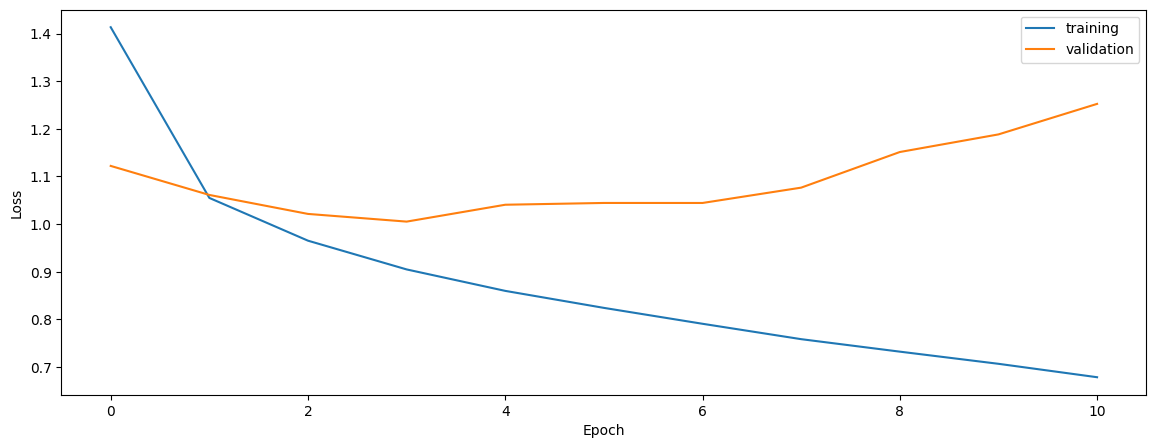

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.662466919607896
0.5976604528962842
0.5994129068047337


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5989745533519095
0.6050736108912459
0.5791804635761589


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5882704124276316
0.5901621324539709
0.5755085812736068


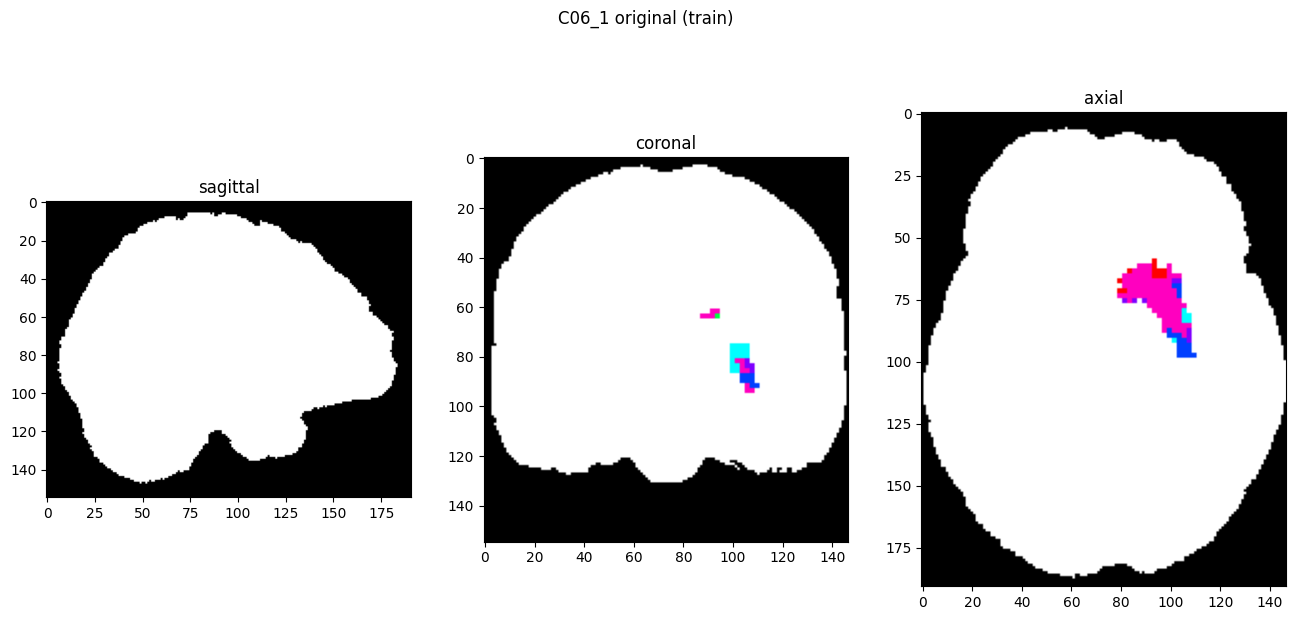

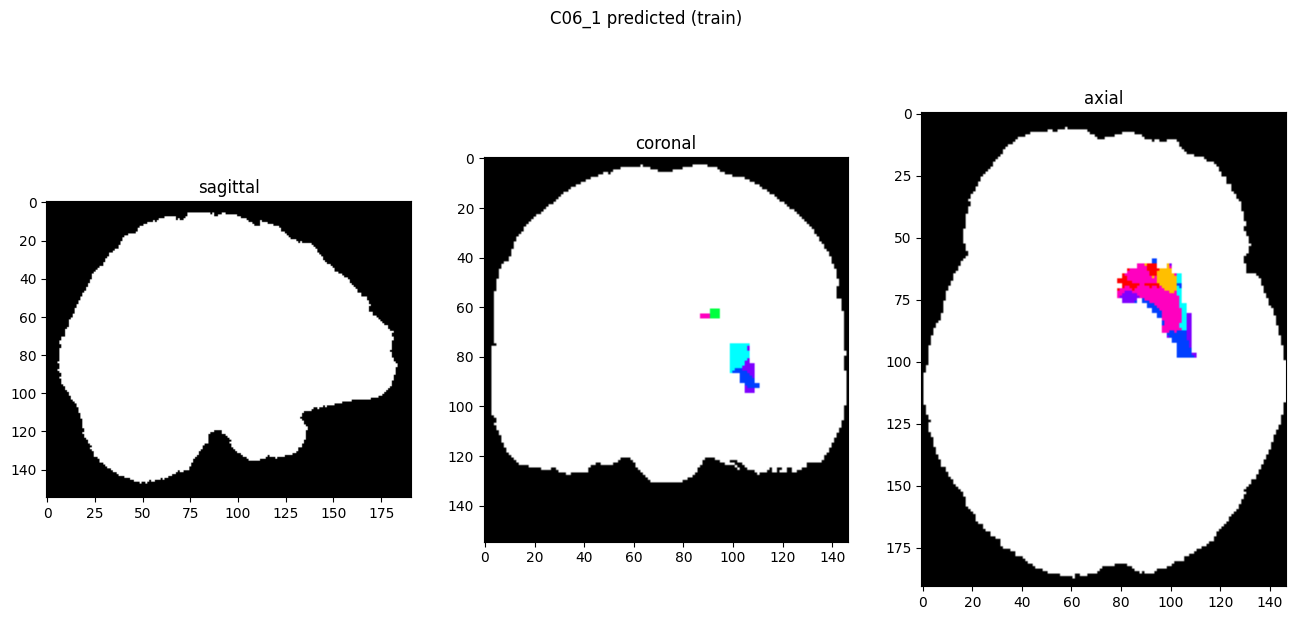

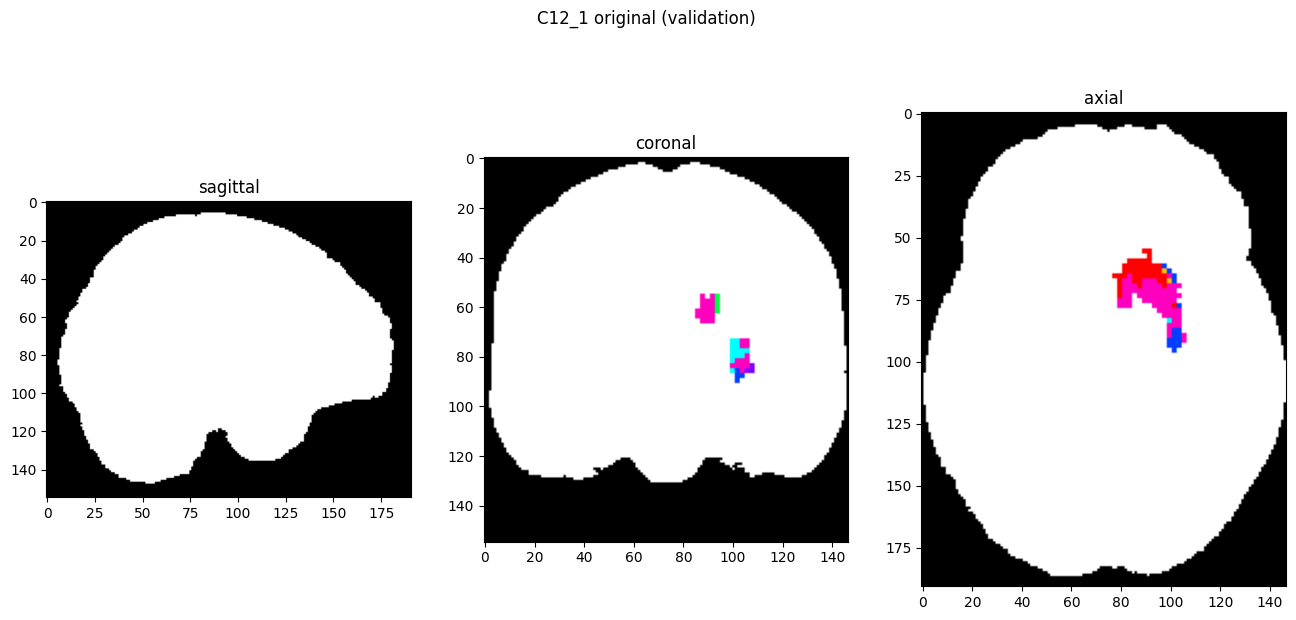

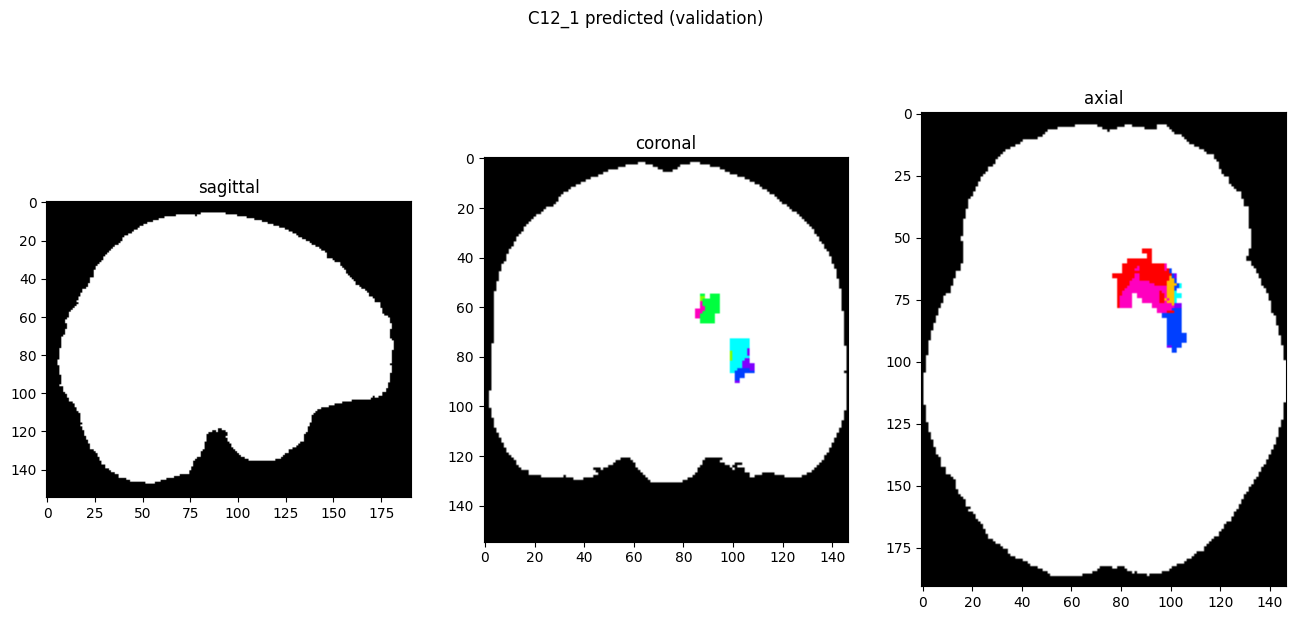

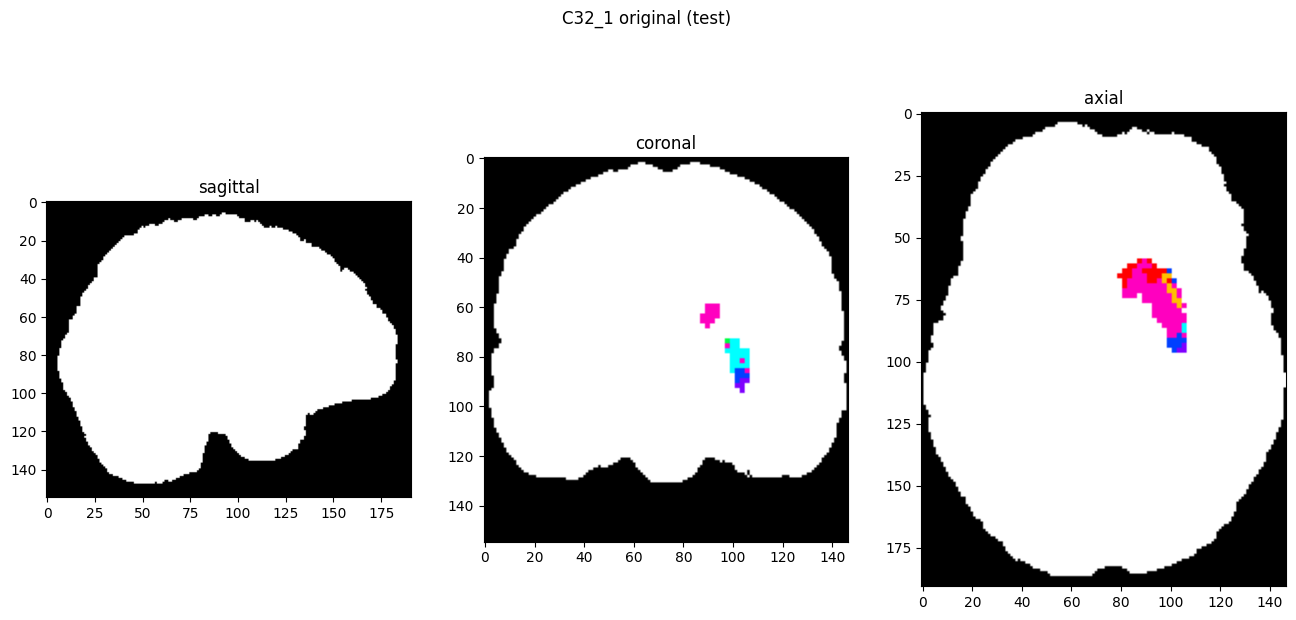

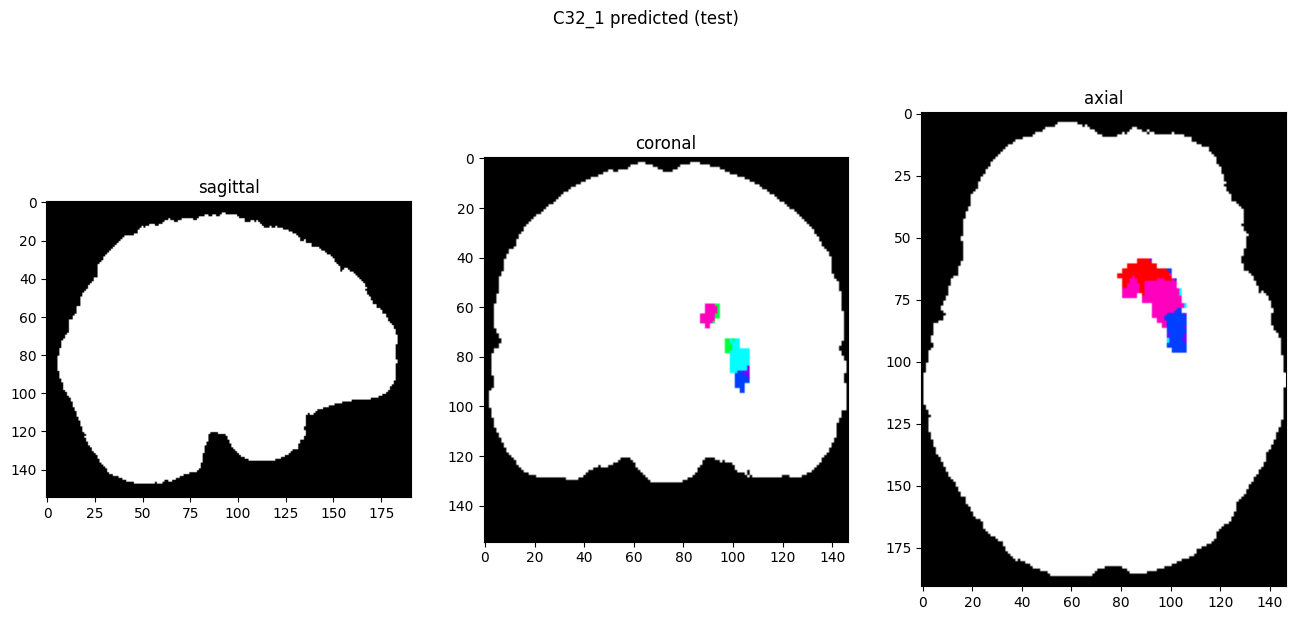

In [10]:
showResults(model, gen, threshold=0)